# Recurrent Neural Network predicting price change

We will use Keras to be able to modify the layers.
Import modules.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from keras.callbacks import EarlyStopping

We will use a **Neural Recurrent Network** because it is able to learn the pattern of sequences by its recurrent nature: it has weights connected betweeen the sequence tokens; and the input (xT) is multiplied with previou output (hT-1). There are several types of Recurrent Neural Networks: a simple RNN, a LSTM and GRU. We will consider a simple RNN and LSTM. A LSTM (Long short term memory) is more complex and are introducing 2 more gates. A 'forget' and a 'output' gate.

A Recurrent Neural Network takes sequences as input.
As target we will use the next price change in the sequence. 
However as it is more interesting to try to predict in what direction the price goes, we will use the encoded version of the price change. ***Positive and Negative***

## Load the dataset

In [9]:
dailyChanges = pd.read_csv('./preprocessing/all_pricesAverages.csv')

In [10]:
print(dailyChanges.columns)
print(dailyChanges.shape)

dailyChanges.head()

Index(['date', 'open', 'close', 'low', 'high', 'volume', 'change',
       'stability'],
      dtype='object')
(1510, 8)


,date,open,close,low,high,volume,change,stability
0,2011-01-03,47.020216,47.210714,46.740986,47.633616,6.460778e+06,-0.344929,0
1,2011-01-04,47.286887,46.866950,46.419376,47.517700,6.738886e+06,0.811473,1
2,2011-01-05,46.697300,47.126548,46.452693,47.410466,7.073876e+06,-0.913005,0
3,2011-01-06,47.153983,46.998321,46.591836,47.550025,7.430919e+06,0.237169,1
4,2011-01-07,47.091944,46.952507,46.439834,47.435790,7.579271e+06,0.259163,1


---
## Split the data

We need to split the data into x and y and hot encode y so it fits the Neural Network.
x needs to be a sequence of an arbitrary length (a length that would predict next price change)

We are defining a sequence function like the one defined in tutorial 9.

It is also important not to shuffle the data as the order is important for the sequences.

In [11]:

#Helper function defined in Tutorial 9.
#Parameters:
#seq_size is how long the size of the frame should be
#df is the dataframe object
def to_sequences(seq_size, df):
    x = []
    y = []
    changes = df.change.tolist() ##The x values
    stabilityLabel = df.stability.tolist() ##The labels
    for i in range(len(stabilityLabel)-SEQUENCE_SIZE-1):
        window = stabilityLabel[i:(i+SEQUENCE_SIZE)] #Get specified numbers of price changes into X
        after_window = stabilityLabel[i+SEQUENCE_SIZE]
        window = [[x] for x in window] #convert window to array for correct format for the RNN with 3d
        x.append(window)
        y.append(after_window)        
    return np.array(x),np.array(y) ##Convert normal list to numpy array for correct format

SEQUENCE_SIZE = 10
X,y = to_sequences(SEQUENCE_SIZE, dailyChanges)


print(X.shape)

##It might also be a good idea to transform the data so it has mean 0 and standard deviation 1 
#https://medium.com/predict/standardization-on-crazy-data-python-cd5b1282a97f?



(1499, 10, 1)


# Visualize X and y




first sequence:  [[0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]]
first label:  0
second sequence:  [[1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]]
second label:  1


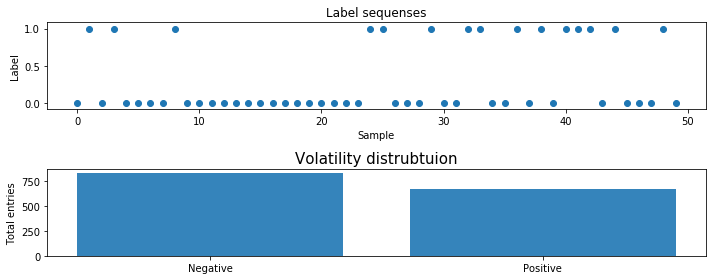

In [12]:
fig, axes = plt.subplots(2,1, figsize=(10,4))

axes[0].set_title("Label sequenses")

axes[0].set_ylabel("Label")
axes[0].set_xlabel("Sample")
axes[0].scatter(np.arange(len(X[:50])),y[:50])


plt
def plotStability(y, title):
    xLabels = ('Negative', 'Positive')
    yPos = np.arange(len(xLabels))
    yEntries = [0, 0]
    uniques = np.unique(y, return_counts=True) #Getting the counts of the labels as [[label1, label2],[count1, count2]]
    yEntries[0] = uniques[1][0]
    yEntries[1] = uniques[1][1]
    axes[1].bar(yPos, yEntries, align = 'center', alpha = 0.9)
    plt.xticks(yPos, xLabels)
    axes[1].set_ylabel("Total entries")
    axes[1].set_title(title, fontsize=15)
    
plotStability(y, title="Volatility distrubtuion")
plt.tight_layout()


lenOfX = [len(x) for x in X]
print("first sequence: ",X[0])
print("first label: ",y[0])
print("second sequence: ",X[1])
print("second label: ",y[1])

***First figure is showing sequences and the RNN will try to predict an arbritary point in that figure by processing a sequence of earlier tokens.***

***

### One-Hot encode y and split data into training and test sets
We are using Keras to_categorical to get a hot encoding and Sklearn's train_test_split function with a 15 % test set. We are choosing a relativley low test set because we want to keep as much data in the training as possible.

In [13]:
y = to_categorical(y) #Hot encode it

##Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15)

print(X_train.shape)
print(X_train[0])
print(y_train[0]) #Prints the next 

(1274, 10, 1)
[[1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]]
[1. 0.]


***
# Set up the network and train it

We are using a Recurrent Neural Network which means that the output of the current timestep becomes input to the next timestep, allowing the ANN to have a memory.


#### Recurrent Neural Network Layers
***1.*** 
First RNN layer we are using is the SimpleRNN that comes with Keras. It is using a 
***Backpropogation through time (BPTT)***.
However, this method is subject to the vanishing gradient problem and therefore we will consider using LSTM that has been developed to address this problem. https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484

***2.*** 
We will then compare it to a ***LSTM (Long Short Term Memory)***.
The time steps are then trainable and can choose to keep information depending on importance.
The LSTM layer has 3 gates. These gates are a "forget" gate for discarding information, an "input" gate for handling current input and a "output" gate for producing predictions for each time step. (https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470)


#### input 3D [rows, timestep, columns]
We have 1 time step as we are shifting the sequence 1 step in every sample.



### Hyper parameters

#### Optimizer
We are using adam as optimizer. An optimizer improved from the classic Stochastic Gradient Descent.

      Adam was introduced 2015 by Diedrik Kingma from OpenAI
   
   ##### pros:
       Easy to implement
       computationally efficient
       Little memory requirments
       Invariant to diagonal rescale of the gradients
       Well suited for problems that are large in terms of data and/or paramters
       Appropiate for problems with very noisy and/or sparse gradients
       Hyper parameters have intuitive interpretation and typically require little tuning
       
   ##### Appicable to our problem:
       Adam combines two extensions of Stochastic Gradient. Normal stochastic gradient has the same learning rate for all weight updates which means it could fall into a local minimia or "overshoot" and never find the minima.
       
       
       Adam on the other hand maintains learning rate for each weight in the network. It does so by adapting the stochastic gradient extension (AdaGrad) that maintains a per-parameter learning rate that improves problems with sparse gradients. It also adapts Root mean square propogation 'RMSProp' that maintains a per-parameter learning rate that are changed based on the average of recent magnitude of the gradient which means the algorithm does well on online and non-stationary problems (e.g. noisy, which our data is).
        
       
https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/


****


#### Activation functions
We will use ReLU activation function in the hidden layers as it is also addressing the vanishing gradient problem by not squashing the input into a small region like, for example, sigmoid does. Instead it maps input space  : :x to max(0, x).

We will use softmax as activation function to get a probability for each label.
 $f(s)_{i} = \frac{e^{s_{i}}}{\sum_{j}^{C} e^{s_{j}}}$


#### Layers
As the decision boundary is difficult to guess we will test/try with different width and depth of the network. 

Something clear is that we have 3 nodes in the last layer and are using a softmax activation function to get a probability for every category. 


****


#### Loss function
The loss function to be optimized is **categorical crossentropy** as it is the choice for categorical classifications.

***

#### Batch size

The batch size of a neural network is the number of samples the network considers before updating its weights.
The weights will be updated after every epoch (batch learning). The smaller the batch, the faster the model will train, but the less accurate it becomes. **We will experiment with different batch sizes.**

****

#### Evaluation 
###### Accuarcy = Total correct / total
#### Precision for each label
#### Recall for each precsion 
###### ROC = Receiver operating characteristic curve (a.k.a ROC) is a graphic plot illustrating the diagnostic ability of its discrimination threshold.
###### AUC = Area Under the Curve is the percentage of the area that is under this ROC curve, ranging between 0~1.  

We will use a mix of all these evaluations in order to see how the classifier is performing.

***


# Simple RNN

First we run the model with initial settings for 1000 epochs to try to see where it converges.

## Let us see how well it fits the training data and generlizes at different epochs.

In [14]:
history = None

def create_and_run_RNN( ep, typeOfRnn="Simple", more_layers=False, withDropOut=False):
        model = Sequential()
        if typeOfRnn == "Simple":
            model.add(SimpleRNN(16, input_shape=(None, 1)))
        elif typeOfRnn == 'LSTM':
            model.add(LSTM(16, input_shape=(None, 1)))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu'))
        if more_layers == True:
            model.add(Dense(8, activation='relu'))
          
            
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        model.summary()
     
        ##Regularization
        #monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=7, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        ##Precision and recall
    
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
       
   
        
        return history

model = create_and_run_RNN(1000) #Run with 20 epochs and the defauly RNN layer that is SimpleRNN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 16)                288       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 18        
Total params: 514
Trainable params: 514
Non-trainable params: 0
_________________________________________________________________
Train on 1274 samples, validate on 225 samples
Epoch 1/1000
 - 1s - loss: 0.6904 - accuracy: 0.5495 - val_loss: 0.6863 - val_accuracy: 0.5689
Epoch 2/1000
 - 0s - loss: 0.6882 - accuracy: 0.5518 - val_loss: 0.6861 - val_accuracy: 0.5689
Epoch 3/1000
 - 0

Epoch 77/1000
 - 0s - loss: 0.6363 - accuracy: 0.6460 - val_loss: 0.7900 - val_accuracy: 0.4978
Epoch 78/1000
 - 0s - loss: 0.6311 - accuracy: 0.6546 - val_loss: 0.7670 - val_accuracy: 0.5022
Epoch 79/1000
 - 0s - loss: 0.6280 - accuracy: 0.6601 - val_loss: 0.7937 - val_accuracy: 0.4978
Epoch 80/1000
 - 0s - loss: 0.6258 - accuracy: 0.6633 - val_loss: 0.7817 - val_accuracy: 0.5200
Epoch 81/1000
 - 0s - loss: 0.6266 - accuracy: 0.6593 - val_loss: 0.7746 - val_accuracy: 0.4933
Epoch 82/1000
 - 0s - loss: 0.6320 - accuracy: 0.6538 - val_loss: 0.7644 - val_accuracy: 0.5200
Epoch 83/1000
 - 0s - loss: 0.6265 - accuracy: 0.6538 - val_loss: 0.7960 - val_accuracy: 0.4844
Epoch 84/1000
 - 0s - loss: 0.6258 - accuracy: 0.6460 - val_loss: 0.7773 - val_accuracy: 0.5111
Epoch 85/1000
 - 0s - loss: 0.6270 - accuracy: 0.6515 - val_loss: 0.7868 - val_accuracy: 0.4933
Epoch 86/1000
 - 0s - loss: 0.6267 - accuracy: 0.6633 - val_loss: 0.7868 - val_accuracy: 0.4978
Epoch 87/1000
 - 0s - loss: 0.6226 - acc

Epoch 162/1000
 - 0s - loss: 0.5829 - accuracy: 0.6829 - val_loss: 0.8796 - val_accuracy: 0.5378
Epoch 163/1000
 - 0s - loss: 0.5818 - accuracy: 0.6915 - val_loss: 0.9126 - val_accuracy: 0.5422
Epoch 164/1000
 - 0s - loss: 0.5806 - accuracy: 0.6860 - val_loss: 0.9070 - val_accuracy: 0.5378
Epoch 165/1000
 - 0s - loss: 0.5749 - accuracy: 0.7041 - val_loss: 0.9517 - val_accuracy: 0.5156
Epoch 166/1000
 - 1s - loss: 0.5824 - accuracy: 0.6923 - val_loss: 0.8818 - val_accuracy: 0.5378
Epoch 167/1000
 - 0s - loss: 0.5821 - accuracy: 0.6907 - val_loss: 0.9002 - val_accuracy: 0.5333
Epoch 168/1000
 - 0s - loss: 0.5720 - accuracy: 0.7025 - val_loss: 0.9853 - val_accuracy: 0.5200
Epoch 169/1000
 - 0s - loss: 0.5753 - accuracy: 0.6931 - val_loss: 0.8972 - val_accuracy: 0.5244
Epoch 170/1000
 - 0s - loss: 0.5761 - accuracy: 0.6947 - val_loss: 0.9236 - val_accuracy: 0.5244
Epoch 171/1000
 - 0s - loss: 0.5757 - accuracy: 0.7017 - val_loss: 0.8714 - val_accuracy: 0.5244
Epoch 172/1000
 - 1s - loss: 0

Epoch 247/1000
 - 0s - loss: 0.5502 - accuracy: 0.7151 - val_loss: 1.0327 - val_accuracy: 0.5422
Epoch 248/1000
 - 0s - loss: 0.5491 - accuracy: 0.7104 - val_loss: 1.0583 - val_accuracy: 0.5200
Epoch 249/1000
 - 0s - loss: 0.5525 - accuracy: 0.7159 - val_loss: 1.0063 - val_accuracy: 0.5378
Epoch 250/1000
 - 0s - loss: 0.5517 - accuracy: 0.7159 - val_loss: 0.9799 - val_accuracy: 0.5333
Epoch 251/1000
 - 0s - loss: 0.5481 - accuracy: 0.7127 - val_loss: 0.9455 - val_accuracy: 0.5378
Epoch 252/1000
 - 0s - loss: 0.5525 - accuracy: 0.7072 - val_loss: 0.9916 - val_accuracy: 0.5333
Epoch 253/1000
 - 0s - loss: 0.5458 - accuracy: 0.7143 - val_loss: 1.0169 - val_accuracy: 0.5511
Epoch 254/1000
 - 0s - loss: 0.5547 - accuracy: 0.7214 - val_loss: 1.0272 - val_accuracy: 0.5422
Epoch 255/1000
 - 0s - loss: 0.5517 - accuracy: 0.7127 - val_loss: 0.9711 - val_accuracy: 0.5600
Epoch 256/1000
 - 0s - loss: 0.5525 - accuracy: 0.7166 - val_loss: 1.0333 - val_accuracy: 0.5333
Epoch 257/1000
 - 0s - loss: 0

Epoch 332/1000
 - 0s - loss: 0.5367 - accuracy: 0.7292 - val_loss: 1.0715 - val_accuracy: 0.5556
Epoch 333/1000
 - 0s - loss: 0.5396 - accuracy: 0.7174 - val_loss: 1.0406 - val_accuracy: 0.5378
Epoch 334/1000
 - 0s - loss: 0.5437 - accuracy: 0.7080 - val_loss: 1.0276 - val_accuracy: 0.5422
Epoch 335/1000
 - 0s - loss: 0.5325 - accuracy: 0.7237 - val_loss: 1.0567 - val_accuracy: 0.5511
Epoch 336/1000
 - 0s - loss: 0.5358 - accuracy: 0.7206 - val_loss: 1.0642 - val_accuracy: 0.5467
Epoch 337/1000
 - 0s - loss: 0.5351 - accuracy: 0.7198 - val_loss: 1.1267 - val_accuracy: 0.5333
Epoch 338/1000
 - 0s - loss: 0.5342 - accuracy: 0.7190 - val_loss: 0.9516 - val_accuracy: 0.5644
Epoch 339/1000
 - 0s - loss: 0.5317 - accuracy: 0.7221 - val_loss: 1.1282 - val_accuracy: 0.5378
Epoch 340/1000
 - 0s - loss: 0.5276 - accuracy: 0.7253 - val_loss: 1.0231 - val_accuracy: 0.5511
Epoch 341/1000
 - 0s - loss: 0.5353 - accuracy: 0.7229 - val_loss: 1.0299 - val_accuracy: 0.5378
Epoch 342/1000
 - 0s - loss: 0

Epoch 417/1000
 - 0s - loss: 0.5160 - accuracy: 0.7261 - val_loss: 1.1002 - val_accuracy: 0.5556
Epoch 418/1000
 - 0s - loss: 0.5145 - accuracy: 0.7221 - val_loss: 1.0209 - val_accuracy: 0.5733
Epoch 419/1000
 - 0s - loss: 0.5133 - accuracy: 0.7316 - val_loss: 1.0863 - val_accuracy: 0.5422
Epoch 420/1000
 - 0s - loss: 0.5161 - accuracy: 0.7190 - val_loss: 1.0587 - val_accuracy: 0.5511
Epoch 421/1000
 - 0s - loss: 0.5084 - accuracy: 0.7331 - val_loss: 1.0453 - val_accuracy: 0.5733
Epoch 422/1000
 - 0s - loss: 0.5218 - accuracy: 0.7174 - val_loss: 1.0155 - val_accuracy: 0.5378
Epoch 423/1000
 - 0s - loss: 0.5116 - accuracy: 0.7331 - val_loss: 1.0862 - val_accuracy: 0.5378
Epoch 424/1000
 - 0s - loss: 0.5151 - accuracy: 0.7229 - val_loss: 1.1116 - val_accuracy: 0.5422
Epoch 425/1000
 - 0s - loss: 0.5233 - accuracy: 0.7166 - val_loss: 1.0812 - val_accuracy: 0.5378
Epoch 426/1000
 - 0s - loss: 0.5134 - accuracy: 0.7214 - val_loss: 1.1197 - val_accuracy: 0.5467
Epoch 427/1000
 - 0s - loss: 0

Epoch 502/1000
 - 0s - loss: 0.5000 - accuracy: 0.7386 - val_loss: 1.1310 - val_accuracy: 0.5289
Epoch 503/1000
 - 0s - loss: 0.5000 - accuracy: 0.7378 - val_loss: 1.1783 - val_accuracy: 0.5333
Epoch 504/1000
 - 0s - loss: 0.5006 - accuracy: 0.7386 - val_loss: 1.1024 - val_accuracy: 0.5556
Epoch 505/1000
 - 0s - loss: 0.5007 - accuracy: 0.7261 - val_loss: 1.1464 - val_accuracy: 0.5644
Epoch 506/1000
 - 0s - loss: 0.5094 - accuracy: 0.7276 - val_loss: 1.1471 - val_accuracy: 0.5333
Epoch 507/1000
 - 0s - loss: 0.4984 - accuracy: 0.7339 - val_loss: 1.1087 - val_accuracy: 0.5778
Epoch 508/1000
 - 0s - loss: 0.5123 - accuracy: 0.7261 - val_loss: 1.1314 - val_accuracy: 0.5422
Epoch 509/1000
 - 0s - loss: 0.5016 - accuracy: 0.7323 - val_loss: 1.1330 - val_accuracy: 0.5511
Epoch 510/1000
 - 0s - loss: 0.4996 - accuracy: 0.7386 - val_loss: 1.1178 - val_accuracy: 0.5422
Epoch 511/1000
 - 0s - loss: 0.5047 - accuracy: 0.7370 - val_loss: 1.1292 - val_accuracy: 0.5467
Epoch 512/1000
 - 0s - loss: 0

Epoch 587/1000
 - 0s - loss: 0.4967 - accuracy: 0.7276 - val_loss: 1.1608 - val_accuracy: 0.5289
Epoch 588/1000
 - 0s - loss: 0.4977 - accuracy: 0.7394 - val_loss: 1.1937 - val_accuracy: 0.5422
Epoch 589/1000
 - 0s - loss: 0.4964 - accuracy: 0.7261 - val_loss: 1.2222 - val_accuracy: 0.5156
Epoch 590/1000
 - 0s - loss: 0.4959 - accuracy: 0.7300 - val_loss: 1.1129 - val_accuracy: 0.5333
Epoch 591/1000
 - 0s - loss: 0.4948 - accuracy: 0.7253 - val_loss: 1.2126 - val_accuracy: 0.5422
Epoch 592/1000
 - 0s - loss: 0.4975 - accuracy: 0.7245 - val_loss: 1.1177 - val_accuracy: 0.5467
Epoch 593/1000
 - 0s - loss: 0.4916 - accuracy: 0.7316 - val_loss: 1.1219 - val_accuracy: 0.5422
Epoch 594/1000
 - 0s - loss: 0.4952 - accuracy: 0.7159 - val_loss: 1.1269 - val_accuracy: 0.5511
Epoch 595/1000
 - 0s - loss: 0.4940 - accuracy: 0.7347 - val_loss: 1.1168 - val_accuracy: 0.5467
Epoch 596/1000
 - 0s - loss: 0.5059 - accuracy: 0.7316 - val_loss: 1.1484 - val_accuracy: 0.5244
Epoch 597/1000
 - 0s - loss: 0

Epoch 672/1000
 - 0s - loss: 0.4947 - accuracy: 0.7308 - val_loss: 1.2422 - val_accuracy: 0.5289
Epoch 673/1000
 - 0s - loss: 0.4964 - accuracy: 0.7355 - val_loss: 1.2593 - val_accuracy: 0.5200
Epoch 674/1000
 - 0s - loss: 0.4922 - accuracy: 0.7300 - val_loss: 1.2559 - val_accuracy: 0.5156
Epoch 675/1000
 - 0s - loss: 0.4925 - accuracy: 0.7292 - val_loss: 1.1987 - val_accuracy: 0.5333
Epoch 676/1000
 - 0s - loss: 0.4885 - accuracy: 0.7425 - val_loss: 1.1862 - val_accuracy: 0.5600
Epoch 677/1000
 - 0s - loss: 0.4872 - accuracy: 0.7284 - val_loss: 1.1850 - val_accuracy: 0.5556
Epoch 678/1000
 - 0s - loss: 0.4978 - accuracy: 0.7331 - val_loss: 1.2129 - val_accuracy: 0.5600
Epoch 679/1000
 - 0s - loss: 0.4823 - accuracy: 0.7363 - val_loss: 1.1746 - val_accuracy: 0.5333
Epoch 680/1000
 - 0s - loss: 0.4856 - accuracy: 0.7331 - val_loss: 1.2345 - val_accuracy: 0.5333
Epoch 681/1000
 - 0s - loss: 0.4880 - accuracy: 0.7308 - val_loss: 1.1859 - val_accuracy: 0.5200
Epoch 682/1000
 - 0s - loss: 0

Epoch 757/1000
 - 0s - loss: 0.4788 - accuracy: 0.7386 - val_loss: 1.1724 - val_accuracy: 0.5556
Epoch 758/1000
 - 0s - loss: 0.4817 - accuracy: 0.7378 - val_loss: 1.2056 - val_accuracy: 0.5778
Epoch 759/1000
 - 0s - loss: 0.4873 - accuracy: 0.7418 - val_loss: 1.2283 - val_accuracy: 0.5511
Epoch 760/1000
 - 0s - loss: 0.4782 - accuracy: 0.7355 - val_loss: 1.2368 - val_accuracy: 0.5467
Epoch 761/1000
 - 0s - loss: 0.4845 - accuracy: 0.7339 - val_loss: 1.1943 - val_accuracy: 0.5600
Epoch 762/1000
 - 0s - loss: 0.4747 - accuracy: 0.7425 - val_loss: 1.2040 - val_accuracy: 0.5822
Epoch 763/1000
 - 0s - loss: 0.4811 - accuracy: 0.7449 - val_loss: 1.1965 - val_accuracy: 0.5378
Epoch 764/1000
 - 0s - loss: 0.4859 - accuracy: 0.7355 - val_loss: 1.1945 - val_accuracy: 0.5422
Epoch 765/1000
 - 0s - loss: 0.4743 - accuracy: 0.7410 - val_loss: 1.2006 - val_accuracy: 0.5689
Epoch 766/1000
 - 0s - loss: 0.4835 - accuracy: 0.7402 - val_loss: 1.2682 - val_accuracy: 0.5600
Epoch 767/1000
 - 0s - loss: 0

Epoch 842/1000
 - 0s - loss: 0.4775 - accuracy: 0.7355 - val_loss: 1.2082 - val_accuracy: 0.5556
Epoch 843/1000
 - 0s - loss: 0.4756 - accuracy: 0.7410 - val_loss: 1.2235 - val_accuracy: 0.5378
Epoch 844/1000
 - 0s - loss: 0.4833 - accuracy: 0.7441 - val_loss: 1.2109 - val_accuracy: 0.5378
Epoch 845/1000
 - 0s - loss: 0.4692 - accuracy: 0.7410 - val_loss: 1.1827 - val_accuracy: 0.5467
Epoch 846/1000
 - 0s - loss: 0.4778 - accuracy: 0.7418 - val_loss: 1.1414 - val_accuracy: 0.5644
Epoch 847/1000
 - 0s - loss: 0.5521 - accuracy: 0.7080 - val_loss: 1.1269 - val_accuracy: 0.5867
Epoch 848/1000
 - 0s - loss: 0.4950 - accuracy: 0.7410 - val_loss: 1.1903 - val_accuracy: 0.5467
Epoch 849/1000
 - 0s - loss: 0.4827 - accuracy: 0.7386 - val_loss: 1.1697 - val_accuracy: 0.5200
Epoch 850/1000
 - 0s - loss: 0.4843 - accuracy: 0.7457 - val_loss: 1.1253 - val_accuracy: 0.5556
Epoch 851/1000
 - 0s - loss: 0.4691 - accuracy: 0.7512 - val_loss: 1.1578 - val_accuracy: 0.5644
Epoch 852/1000
 - 1s - loss: 0

Epoch 927/1000
 - 0s - loss: 0.4731 - accuracy: 0.7457 - val_loss: 1.1994 - val_accuracy: 0.5467
Epoch 928/1000
 - 0s - loss: 0.4736 - accuracy: 0.7402 - val_loss: 1.2438 - val_accuracy: 0.5778
Epoch 929/1000
 - 0s - loss: 0.4667 - accuracy: 0.7527 - val_loss: 1.2054 - val_accuracy: 0.5689
Epoch 930/1000
 - 0s - loss: 0.4780 - accuracy: 0.7386 - val_loss: 1.2393 - val_accuracy: 0.5333
Epoch 931/1000
 - 0s - loss: 0.4740 - accuracy: 0.7457 - val_loss: 1.2466 - val_accuracy: 0.5733
Epoch 932/1000
 - 0s - loss: 0.4739 - accuracy: 0.7575 - val_loss: 1.1994 - val_accuracy: 0.5778
Epoch 933/1000
 - 0s - loss: 0.4818 - accuracy: 0.7370 - val_loss: 1.2257 - val_accuracy: 0.5600
Epoch 934/1000
 - 0s - loss: 0.4620 - accuracy: 0.7520 - val_loss: 1.2725 - val_accuracy: 0.5689
Epoch 935/1000
 - 0s - loss: 0.4689 - accuracy: 0.7535 - val_loss: 1.3003 - val_accuracy: 0.5289
Epoch 936/1000
 - 0s - loss: 0.4824 - accuracy: 0.7394 - val_loss: 1.2150 - val_accuracy: 0.5467
Epoch 937/1000
 - 0s - loss: 0

## Evaluate performance metrics on validation set and training set

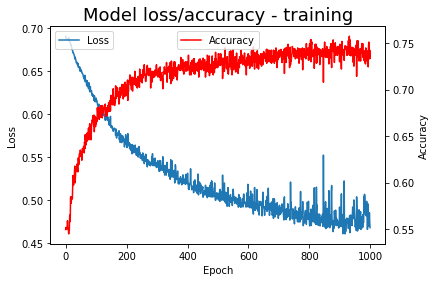

<Figure size 432x288 with 0 Axes>

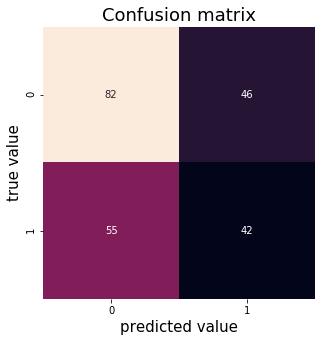

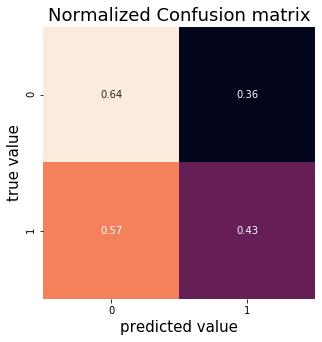

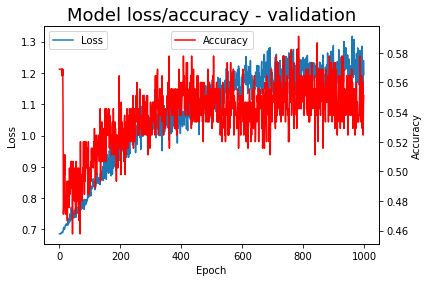

              precision    recall  f1-score   support

           0       0.60      0.64      0.62       128
           1       0.48      0.43      0.45        97

    accuracy                           0.55       225
   macro avg       0.54      0.54      0.54       225
weighted avg       0.55      0.55      0.55       225



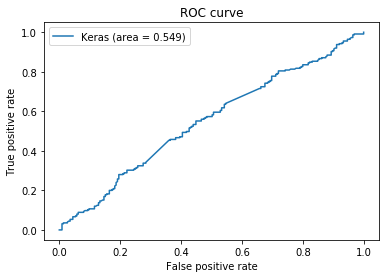

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### Training loss/ Accuracy    

def evaluate_mode(model):

    plt.figure()
    plt.plot(model.history['loss'])
    plt.title('Model loss/accuracy - training', fontsize=18)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Loss'], loc='upper left')
    plt2=plt.twinx()
    color = 'red'
    plt2.plot(model.history['accuracy'],color=color)
    plt.ylabel('Accuracy')
    plt2.legend(['Accuracy'], loc='upper center')
    plt.show()


    plt.figure()
    
        
    y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
    pred = [np.argmax(x) for x in model.pred] #ecode from one-hot encoding
    
    ##Confusion amtrix
    cm = confusion_matrix(y_compare, pred) ##For evaluation later
    normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
 
    

            
    plt.figure(figsize=(5,5))
    #Show confion matrix for last epoch 
    plt.title("Confusion matrix", fontsize=18)
    ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
    ax.set_ylim(2,0) #maked heatmap showiung all squares
    plt.xlabel('predicted value', fontsize=15)
    plt.ylabel('true value',  fontsize=15);
    
    
    ##Normalized confusion matrix
    plt.figure(figsize=(5,5))
    #Show confion matrix for last epoch 
    plt.title("Normalized Confusion matrix", fontsize=18)
    ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
    ax.set_ylim(2,0) #maked heatmap showiung all squares
    plt.xlabel('predicted value', fontsize=15)
    plt.ylabel('true value',  fontsize=15);

        
    plt.figure()
    ### Validation loss/ Accuracy 
    plt.plot(model.history['val_loss'])
    plt.title('Model loss/accuracy - validation', fontsize=18)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Loss'], loc='upper left')
    plt2=plt.twinx()
    color = 'red'
    plt2.plot(model.history['val_accuracy'],color=color)
    plt.ylabel('Accuracy')
    plt2.legend(['Accuracy'], loc='upper center')
    plt.show()

    ##Examine the probability distrubtion of the softmax output
    np.set_printoptions(suppress=True)

 
    print(classification_report(y_compare, pred))
    
    
    #Plot the ROC and AUC
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test.ravel(), model.pred.ravel())
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')


evaluate_mode(model)


The recall is telling us that the model is more biased to classify a value as a negative. Here we were experimenting with different sequence sizes. The code for that can be found in the very end of this notebook. We found out that a sequence of 5 tokens was underfitting.

***
## LSTM (Long short term memory)

LSMT with its 2 extra gates (update, output) has 2 more weight sets which implies there will be a larger amount of parameters to train in the first Recurrent layer.

In [17]:
model = create_and_run_RNN(1000, typeOfRnn="LSTM" ) 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 18        
Total params: 1,378
Trainable params: 1,378
Non-trainable params: 0
_________________________________________________________________
Train on 1274 samples, validate on 225 samples
Epoch 1/1000
 - 1s - loss: 0.6892 - accuracy: 0.5526 - val_loss: 0.6839 - val_accuracy: 0.5689
Epoch 2/1000
 - 1s - loss: 0.6882 - accuracy: 0.5518 - val_loss: 0.6852 - val_accuracy: 0.5689
Epoch 3/1000


Epoch 77/1000
 - 1s - loss: 0.6669 - accuracy: 0.6028 - val_loss: 0.7126 - val_accuracy: 0.4756
Epoch 78/1000
 - 1s - loss: 0.6671 - accuracy: 0.5871 - val_loss: 0.7110 - val_accuracy: 0.4889
Epoch 79/1000
 - 1s - loss: 0.6663 - accuracy: 0.5973 - val_loss: 0.7132 - val_accuracy: 0.4889
Epoch 80/1000
 - 1s - loss: 0.6662 - accuracy: 0.5989 - val_loss: 0.7134 - val_accuracy: 0.4800
Epoch 81/1000
 - 1s - loss: 0.6652 - accuracy: 0.6020 - val_loss: 0.7149 - val_accuracy: 0.4800
Epoch 82/1000
 - 1s - loss: 0.6652 - accuracy: 0.5911 - val_loss: 0.7190 - val_accuracy: 0.4756
Epoch 83/1000
 - 1s - loss: 0.6646 - accuracy: 0.5965 - val_loss: 0.7145 - val_accuracy: 0.4844
Epoch 84/1000
 - 1s - loss: 0.6635 - accuracy: 0.6052 - val_loss: 0.7153 - val_accuracy: 0.4978
Epoch 85/1000
 - 1s - loss: 0.6630 - accuracy: 0.6044 - val_loss: 0.7152 - val_accuracy: 0.4844
Epoch 86/1000
 - 1s - loss: 0.6634 - accuracy: 0.6028 - val_loss: 0.7217 - val_accuracy: 0.4844
Epoch 87/1000
 - 1s - loss: 0.6619 - acc

Epoch 162/1000
 - 1s - loss: 0.6108 - accuracy: 0.6586 - val_loss: 0.7464 - val_accuracy: 0.5289
Epoch 163/1000
 - 1s - loss: 0.6084 - accuracy: 0.6641 - val_loss: 0.7534 - val_accuracy: 0.5333
Epoch 164/1000
 - 1s - loss: 0.6088 - accuracy: 0.6695 - val_loss: 0.7486 - val_accuracy: 0.5511
Epoch 165/1000
 - 1s - loss: 0.6053 - accuracy: 0.6735 - val_loss: 0.7515 - val_accuracy: 0.5333
Epoch 166/1000
 - 1s - loss: 0.6090 - accuracy: 0.6703 - val_loss: 0.7580 - val_accuracy: 0.5200
Epoch 167/1000
 - 1s - loss: 0.6048 - accuracy: 0.6625 - val_loss: 0.7528 - val_accuracy: 0.5244
Epoch 168/1000
 - 1s - loss: 0.6056 - accuracy: 0.6656 - val_loss: 0.7517 - val_accuracy: 0.5467
Epoch 169/1000
 - 1s - loss: 0.6031 - accuracy: 0.6633 - val_loss: 0.7536 - val_accuracy: 0.5600
Epoch 170/1000
 - 1s - loss: 0.6039 - accuracy: 0.6743 - val_loss: 0.7521 - val_accuracy: 0.5289
Epoch 171/1000
 - 1s - loss: 0.6052 - accuracy: 0.6617 - val_loss: 0.7412 - val_accuracy: 0.5200
Epoch 172/1000
 - 1s - loss: 0

Epoch 247/1000
 - 1s - loss: 0.5478 - accuracy: 0.7041 - val_loss: 0.8326 - val_accuracy: 0.5422
Epoch 248/1000
 - 1s - loss: 0.5451 - accuracy: 0.7151 - val_loss: 0.8220 - val_accuracy: 0.5467
Epoch 249/1000
 - 1s - loss: 0.5421 - accuracy: 0.7206 - val_loss: 0.8321 - val_accuracy: 0.5556
Epoch 250/1000
 - 1s - loss: 0.5437 - accuracy: 0.7159 - val_loss: 0.8339 - val_accuracy: 0.5422
Epoch 251/1000
 - 1s - loss: 0.5435 - accuracy: 0.7096 - val_loss: 0.8383 - val_accuracy: 0.5556
Epoch 252/1000
 - 1s - loss: 0.5394 - accuracy: 0.7143 - val_loss: 0.8149 - val_accuracy: 0.5556
Epoch 253/1000
 - 1s - loss: 0.5440 - accuracy: 0.7198 - val_loss: 0.8171 - val_accuracy: 0.5289
Epoch 254/1000
 - 1s - loss: 0.5379 - accuracy: 0.7159 - val_loss: 0.8427 - val_accuracy: 0.5333
Epoch 255/1000
 - 1s - loss: 0.5444 - accuracy: 0.7190 - val_loss: 0.8405 - val_accuracy: 0.5511
Epoch 256/1000
 - 1s - loss: 0.5368 - accuracy: 0.7182 - val_loss: 0.8458 - val_accuracy: 0.5378
Epoch 257/1000
 - 1s - loss: 0

Epoch 332/1000
 - 1s - loss: 0.5042 - accuracy: 0.7465 - val_loss: 0.9530 - val_accuracy: 0.5511
Epoch 333/1000
 - 1s - loss: 0.4945 - accuracy: 0.7457 - val_loss: 0.9873 - val_accuracy: 0.5289
Epoch 334/1000
 - 1s - loss: 0.4989 - accuracy: 0.7488 - val_loss: 0.9508 - val_accuracy: 0.5289
Epoch 335/1000
 - 1s - loss: 0.4955 - accuracy: 0.7457 - val_loss: 0.9386 - val_accuracy: 0.5422
Epoch 336/1000
 - 1s - loss: 0.4954 - accuracy: 0.7433 - val_loss: 0.9481 - val_accuracy: 0.5156
Epoch 337/1000
 - 1s - loss: 0.4960 - accuracy: 0.7465 - val_loss: 0.9303 - val_accuracy: 0.5244
Epoch 338/1000
 - 1s - loss: 0.5017 - accuracy: 0.7347 - val_loss: 0.9432 - val_accuracy: 0.5333
Epoch 339/1000
 - 1s - loss: 0.5029 - accuracy: 0.7449 - val_loss: 0.9602 - val_accuracy: 0.5333
Epoch 340/1000
 - 1s - loss: 0.4943 - accuracy: 0.7425 - val_loss: 0.9875 - val_accuracy: 0.5467
Epoch 341/1000
 - 1s - loss: 0.4987 - accuracy: 0.7418 - val_loss: 0.9399 - val_accuracy: 0.5378
Epoch 342/1000
 - 1s - loss: 0

Epoch 417/1000
 - 1s - loss: 0.4759 - accuracy: 0.7386 - val_loss: 1.0705 - val_accuracy: 0.5111
Epoch 418/1000
 - 1s - loss: 0.4671 - accuracy: 0.7614 - val_loss: 1.0701 - val_accuracy: 0.5422
Epoch 419/1000
 - 1s - loss: 0.4620 - accuracy: 0.7630 - val_loss: 1.0664 - val_accuracy: 0.5333
Epoch 420/1000
 - 1s - loss: 0.4678 - accuracy: 0.7598 - val_loss: 1.0732 - val_accuracy: 0.5200
Epoch 421/1000
 - 1s - loss: 0.4701 - accuracy: 0.7575 - val_loss: 1.0915 - val_accuracy: 0.5422
Epoch 422/1000
 - 1s - loss: 0.4717 - accuracy: 0.7677 - val_loss: 1.0682 - val_accuracy: 0.5289
Epoch 423/1000
 - 1s - loss: 0.4690 - accuracy: 0.7582 - val_loss: 1.0994 - val_accuracy: 0.5111
Epoch 424/1000
 - 1s - loss: 0.4762 - accuracy: 0.7520 - val_loss: 1.0771 - val_accuracy: 0.5467
Epoch 425/1000
 - 1s - loss: 0.4697 - accuracy: 0.7582 - val_loss: 1.0696 - val_accuracy: 0.5111
Epoch 426/1000
 - 1s - loss: 0.4689 - accuracy: 0.7543 - val_loss: 1.0667 - val_accuracy: 0.5200
Epoch 427/1000
 - 1s - loss: 0

Epoch 502/1000
 - 1s - loss: 0.4524 - accuracy: 0.7653 - val_loss: 1.1686 - val_accuracy: 0.5244
Epoch 503/1000
 - 1s - loss: 0.4560 - accuracy: 0.7527 - val_loss: 1.1320 - val_accuracy: 0.5378
Epoch 504/1000
 - 1s - loss: 0.4461 - accuracy: 0.7543 - val_loss: 1.1197 - val_accuracy: 0.5289
Epoch 505/1000
 - 1s - loss: 0.4517 - accuracy: 0.7622 - val_loss: 1.1258 - val_accuracy: 0.5511
Epoch 506/1000
 - 1s - loss: 0.4479 - accuracy: 0.7692 - val_loss: 1.1442 - val_accuracy: 0.5333
Epoch 507/1000
 - 1s - loss: 0.4549 - accuracy: 0.7473 - val_loss: 1.1100 - val_accuracy: 0.5333
Epoch 508/1000
 - 1s - loss: 0.4486 - accuracy: 0.7630 - val_loss: 1.1877 - val_accuracy: 0.5378
Epoch 509/1000
 - 1s - loss: 0.4498 - accuracy: 0.7606 - val_loss: 1.1449 - val_accuracy: 0.5333
Epoch 510/1000
 - 1s - loss: 0.4432 - accuracy: 0.7590 - val_loss: 1.1087 - val_accuracy: 0.5200
Epoch 511/1000
 - 1s - loss: 0.4584 - accuracy: 0.7590 - val_loss: 1.1363 - val_accuracy: 0.5333
Epoch 512/1000
 - 1s - loss: 0

Epoch 587/1000
 - 1s - loss: 0.4365 - accuracy: 0.7716 - val_loss: 1.2444 - val_accuracy: 0.5111
Epoch 588/1000
 - 1s - loss: 0.4273 - accuracy: 0.7669 - val_loss: 1.2915 - val_accuracy: 0.5289
Epoch 589/1000
 - 1s - loss: 0.4359 - accuracy: 0.7606 - val_loss: 1.2450 - val_accuracy: 0.5200
Epoch 590/1000
 - 1s - loss: 0.4325 - accuracy: 0.7645 - val_loss: 1.2274 - val_accuracy: 0.5289
Epoch 591/1000
 - 1s - loss: 0.4390 - accuracy: 0.7582 - val_loss: 1.2126 - val_accuracy: 0.5244
Epoch 592/1000
 - 1s - loss: 0.4289 - accuracy: 0.7622 - val_loss: 1.2149 - val_accuracy: 0.5111
Epoch 593/1000
 - 1s - loss: 0.4434 - accuracy: 0.7575 - val_loss: 1.2185 - val_accuracy: 0.5244
Epoch 594/1000
 - 1s - loss: 0.4324 - accuracy: 0.7661 - val_loss: 1.2320 - val_accuracy: 0.5378
Epoch 595/1000
 - 1s - loss: 0.4329 - accuracy: 0.7669 - val_loss: 1.1877 - val_accuracy: 0.5289
Epoch 596/1000
 - 1s - loss: 0.4341 - accuracy: 0.7606 - val_loss: 1.1993 - val_accuracy: 0.5378
Epoch 597/1000
 - 1s - loss: 0

Epoch 672/1000
 - 1s - loss: 0.4306 - accuracy: 0.7575 - val_loss: 1.2818 - val_accuracy: 0.5244
Epoch 673/1000
 - 1s - loss: 0.4185 - accuracy: 0.7684 - val_loss: 1.2375 - val_accuracy: 0.5333
Epoch 674/1000
 - 1s - loss: 0.4229 - accuracy: 0.7661 - val_loss: 1.2186 - val_accuracy: 0.5467
Epoch 675/1000
 - 1s - loss: 0.4205 - accuracy: 0.7708 - val_loss: 1.2415 - val_accuracy: 0.5289
Epoch 676/1000
 - 1s - loss: 0.4193 - accuracy: 0.7677 - val_loss: 1.2666 - val_accuracy: 0.5333
Epoch 677/1000
 - 1s - loss: 0.4203 - accuracy: 0.7677 - val_loss: 1.2659 - val_accuracy: 0.5289
Epoch 678/1000
 - 1s - loss: 0.4134 - accuracy: 0.7794 - val_loss: 1.2951 - val_accuracy: 0.5244
Epoch 679/1000
 - 1s - loss: 0.4276 - accuracy: 0.7622 - val_loss: 1.2554 - val_accuracy: 0.5111
Epoch 680/1000
 - 1s - loss: 0.4223 - accuracy: 0.7684 - val_loss: 1.2596 - val_accuracy: 0.5244
Epoch 681/1000
 - 1s - loss: 0.4183 - accuracy: 0.7708 - val_loss: 1.2905 - val_accuracy: 0.5111
Epoch 682/1000
 - 1s - loss: 0

Epoch 757/1000
 - 1s - loss: 0.4082 - accuracy: 0.7826 - val_loss: 1.3653 - val_accuracy: 0.5111
Epoch 758/1000
 - 2s - loss: 0.4134 - accuracy: 0.7692 - val_loss: 1.3710 - val_accuracy: 0.5200
Epoch 759/1000
 - 1s - loss: 0.4164 - accuracy: 0.7677 - val_loss: 1.3783 - val_accuracy: 0.5067
Epoch 760/1000
 - 2s - loss: 0.4102 - accuracy: 0.7826 - val_loss: 1.3297 - val_accuracy: 0.5244
Epoch 761/1000
 - 2s - loss: 0.4107 - accuracy: 0.7661 - val_loss: 1.3449 - val_accuracy: 0.5333
Epoch 762/1000
 - 1s - loss: 0.4005 - accuracy: 0.7834 - val_loss: 1.2684 - val_accuracy: 0.5244
Epoch 763/1000
 - 1s - loss: 0.4119 - accuracy: 0.7739 - val_loss: 1.3020 - val_accuracy: 0.5067
Epoch 764/1000
 - 1s - loss: 0.4122 - accuracy: 0.7684 - val_loss: 1.3238 - val_accuracy: 0.5156
Epoch 765/1000
 - 1s - loss: 0.4150 - accuracy: 0.7543 - val_loss: 1.3525 - val_accuracy: 0.4978
Epoch 766/1000
 - 1s - loss: 0.4066 - accuracy: 0.7677 - val_loss: 1.2778 - val_accuracy: 0.4889
Epoch 767/1000
 - 1s - loss: 0

Epoch 842/1000
 - 1s - loss: 0.4058 - accuracy: 0.7661 - val_loss: 1.3469 - val_accuracy: 0.5333
Epoch 843/1000
 - 1s - loss: 0.4164 - accuracy: 0.7590 - val_loss: 1.3488 - val_accuracy: 0.5067
Epoch 844/1000
 - 1s - loss: 0.3996 - accuracy: 0.7700 - val_loss: 1.3695 - val_accuracy: 0.5378
Epoch 845/1000
 - 1s - loss: 0.4044 - accuracy: 0.7692 - val_loss: 1.3725 - val_accuracy: 0.5244
Epoch 846/1000
 - 1s - loss: 0.4050 - accuracy: 0.7708 - val_loss: 1.3802 - val_accuracy: 0.5067
Epoch 847/1000
 - 1s - loss: 0.4038 - accuracy: 0.7614 - val_loss: 1.3543 - val_accuracy: 0.5022
Epoch 848/1000
 - 1s - loss: 0.4110 - accuracy: 0.7684 - val_loss: 1.3722 - val_accuracy: 0.5156
Epoch 849/1000
 - 1s - loss: 0.4056 - accuracy: 0.7786 - val_loss: 1.3033 - val_accuracy: 0.5244
Epoch 850/1000
 - 1s - loss: 0.4037 - accuracy: 0.7700 - val_loss: 1.3806 - val_accuracy: 0.5333
Epoch 851/1000
 - 1s - loss: 0.4063 - accuracy: 0.7739 - val_loss: 1.3699 - val_accuracy: 0.4978
Epoch 852/1000
 - 1s - loss: 0

Epoch 927/1000
 - 2s - loss: 0.4038 - accuracy: 0.7708 - val_loss: 1.4274 - val_accuracy: 0.5244
Epoch 928/1000
 - 1s - loss: 0.3996 - accuracy: 0.7669 - val_loss: 1.4258 - val_accuracy: 0.5156
Epoch 929/1000
 - 1s - loss: 0.3975 - accuracy: 0.7739 - val_loss: 1.4152 - val_accuracy: 0.5022
Epoch 930/1000
 - 1s - loss: 0.4035 - accuracy: 0.7669 - val_loss: 1.4194 - val_accuracy: 0.5244
Epoch 931/1000
 - 2s - loss: 0.3966 - accuracy: 0.7684 - val_loss: 1.3903 - val_accuracy: 0.5244
Epoch 932/1000
 - 2s - loss: 0.3972 - accuracy: 0.7684 - val_loss: 1.3822 - val_accuracy: 0.4978
Epoch 933/1000
 - 2s - loss: 0.4001 - accuracy: 0.7598 - val_loss: 1.4229 - val_accuracy: 0.5200
Epoch 934/1000
 - 1s - loss: 0.3959 - accuracy: 0.7763 - val_loss: 1.4316 - val_accuracy: 0.5244
Epoch 935/1000
 - 1s - loss: 0.4000 - accuracy: 0.7677 - val_loss: 1.4036 - val_accuracy: 0.5022
Epoch 936/1000
 - 1s - loss: 0.4039 - accuracy: 0.7677 - val_loss: 1.4085 - val_accuracy: 0.4933
Epoch 937/1000
 - 1s - loss: 0

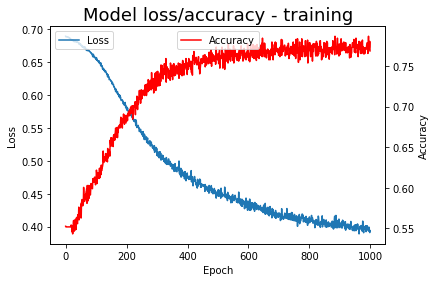

<Figure size 432x288 with 0 Axes>

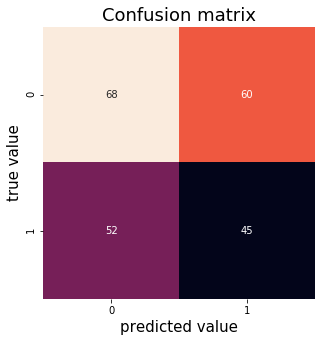

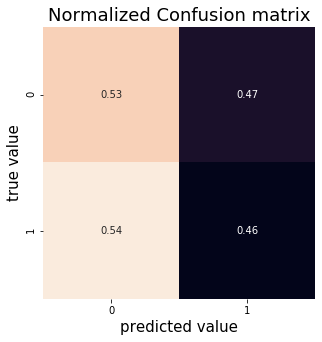

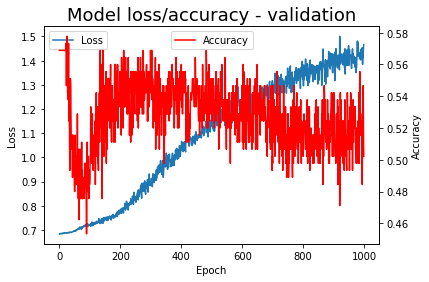

              precision    recall  f1-score   support

           0       0.57      0.53      0.55       128
           1       0.43      0.46      0.45        97

    accuracy                           0.50       225
   macro avg       0.50      0.50      0.50       225
weighted avg       0.51      0.50      0.50       225



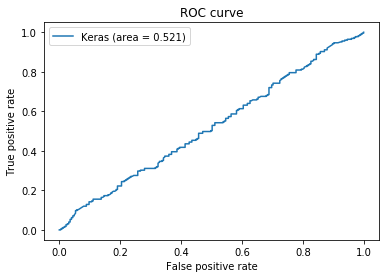

In [19]:
evaluate_mode(model)

***
## Different amount of layers, different batch size and different amount neuron.
We experimented with a lot different and used EarlyStopping as for some runs it never fitted the training data.


In [26]:
history = None

def create_and_run_RNN_more_layers(ep):
        model = Sequential()
       
        model.add(SimpleRNN(16, input_shape=(None, 1)))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu'))
  #     model.add(Dense(8, activation='relu'))
        #model.add(Dense(8, activation='relu'))
        #model.add(Dense(8, activation='relu'))
   
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        model.summary()
       
        ##Regularization
        monitor = EarlyStopping(monitor='loss', min_delta=1e-10, patience=30, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, callbacks=[monitor], batch_size=15, validation_data=(X_test,y_test)) ##Fit the data
        #history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=10, validation_data=(X_test,y_test)) ##Fit the data
        #history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=5, validation_data=(X_test,y_test)) ##Fit the data

    
    
    
        #Evaluation
        ##Precision and recall
    
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
       
   
        
        return history



In [27]:
model = create_and_run_RNN_more_layers(1000 ) 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 16)                288       
_________________________________________________________________
dense_16 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_17 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_21 (Dense)             (None, 2)                

Epoch 73/1000
 - 0s - loss: 0.5476 - accuracy: 0.7104 - val_loss: 0.8431 - val_accuracy: 0.4933
Epoch 74/1000
 - 0s - loss: 0.5488 - accuracy: 0.7159 - val_loss: 0.8195 - val_accuracy: 0.4800
Epoch 75/1000
 - 0s - loss: 0.5413 - accuracy: 0.7143 - val_loss: 0.8572 - val_accuracy: 0.5244
Epoch 76/1000
 - 0s - loss: 0.5458 - accuracy: 0.6994 - val_loss: 0.8262 - val_accuracy: 0.5200
Epoch 77/1000
 - 0s - loss: 0.5486 - accuracy: 0.7174 - val_loss: 0.8412 - val_accuracy: 0.5156
Epoch 78/1000
 - 0s - loss: 0.5415 - accuracy: 0.7072 - val_loss: 0.8360 - val_accuracy: 0.5156
Epoch 79/1000
 - 0s - loss: 0.5422 - accuracy: 0.7064 - val_loss: 0.8285 - val_accuracy: 0.5289
Epoch 80/1000
 - 0s - loss: 0.5370 - accuracy: 0.7151 - val_loss: 0.8457 - val_accuracy: 0.5156
Epoch 81/1000
 - 0s - loss: 0.5377 - accuracy: 0.7174 - val_loss: 0.8775 - val_accuracy: 0.4756
Epoch 82/1000
 - 0s - loss: 0.5303 - accuracy: 0.7292 - val_loss: 0.8538 - val_accuracy: 0.5022
Epoch 83/1000
 - 0s - loss: 0.5249 - acc

Epoch 158/1000
 - 1s - loss: 0.4861 - accuracy: 0.7347 - val_loss: 1.1047 - val_accuracy: 0.4933
Epoch 159/1000
 - 0s - loss: 0.4829 - accuracy: 0.7449 - val_loss: 1.0205 - val_accuracy: 0.5156
Epoch 160/1000
 - 0s - loss: 0.4807 - accuracy: 0.7425 - val_loss: 1.0493 - val_accuracy: 0.5289
Epoch 161/1000
 - 0s - loss: 0.4779 - accuracy: 0.7480 - val_loss: 1.1074 - val_accuracy: 0.5067
Epoch 162/1000
 - 0s - loss: 0.4875 - accuracy: 0.7394 - val_loss: 1.0621 - val_accuracy: 0.5022
Epoch 163/1000
 - 0s - loss: 0.4678 - accuracy: 0.7630 - val_loss: 1.0642 - val_accuracy: 0.5289
Epoch 164/1000
 - 0s - loss: 0.4751 - accuracy: 0.7323 - val_loss: 1.0782 - val_accuracy: 0.4889
Epoch 165/1000
 - 0s - loss: 0.4718 - accuracy: 0.7496 - val_loss: 1.1087 - val_accuracy: 0.5156
Epoch 166/1000
 - 0s - loss: 0.4810 - accuracy: 0.7410 - val_loss: 1.0894 - val_accuracy: 0.5333
Epoch 167/1000
 - 0s - loss: 0.4772 - accuracy: 0.7433 - val_loss: 1.0469 - val_accuracy: 0.5156
Epoch 168/1000
 - 0s - loss: 0

Epoch 243/1000
 - 0s - loss: 0.4593 - accuracy: 0.7575 - val_loss: 1.1327 - val_accuracy: 0.5333
Epoch 244/1000
 - 0s - loss: 0.4477 - accuracy: 0.7559 - val_loss: 1.1482 - val_accuracy: 0.5467
Epoch 245/1000
 - 0s - loss: 0.4418 - accuracy: 0.7543 - val_loss: 1.2137 - val_accuracy: 0.5422
Epoch 246/1000
 - 0s - loss: 0.4486 - accuracy: 0.7488 - val_loss: 1.2307 - val_accuracy: 0.4978
Epoch 247/1000
 - 0s - loss: 0.4555 - accuracy: 0.7567 - val_loss: 1.1615 - val_accuracy: 0.4933
Epoch 248/1000
 - 0s - loss: 0.4550 - accuracy: 0.7606 - val_loss: 1.2452 - val_accuracy: 0.4933
Epoch 249/1000
 - 0s - loss: 0.4527 - accuracy: 0.7520 - val_loss: 1.1731 - val_accuracy: 0.5022
Epoch 250/1000
 - 0s - loss: 0.4478 - accuracy: 0.7480 - val_loss: 1.1708 - val_accuracy: 0.5289
Epoch 251/1000
 - 0s - loss: 0.4537 - accuracy: 0.7551 - val_loss: 1.2127 - val_accuracy: 0.5378
Epoch 252/1000
 - 0s - loss: 0.4508 - accuracy: 0.7684 - val_loss: 1.2125 - val_accuracy: 0.5244
Epoch 253/1000
 - 0s - loss: 0

Epoch 328/1000
 - 0s - loss: 0.4383 - accuracy: 0.7724 - val_loss: 1.2756 - val_accuracy: 0.5022
Epoch 329/1000
 - 0s - loss: 0.4382 - accuracy: 0.7630 - val_loss: 1.3667 - val_accuracy: 0.5422
Epoch 330/1000
 - 0s - loss: 0.4317 - accuracy: 0.7559 - val_loss: 1.3594 - val_accuracy: 0.4933
Epoch 331/1000
 - 0s - loss: 0.4422 - accuracy: 0.7575 - val_loss: 1.3448 - val_accuracy: 0.5200
Epoch 332/1000
 - 0s - loss: 0.4340 - accuracy: 0.7567 - val_loss: 1.3277 - val_accuracy: 0.5378
Epoch 333/1000
 - 0s - loss: 0.4339 - accuracy: 0.7512 - val_loss: 1.3364 - val_accuracy: 0.4844
Epoch 334/1000
 - 0s - loss: 0.4324 - accuracy: 0.7653 - val_loss: 1.3234 - val_accuracy: 0.5200
Epoch 335/1000
 - 0s - loss: 0.4293 - accuracy: 0.7582 - val_loss: 1.2807 - val_accuracy: 0.5600
Epoch 336/1000
 - 0s - loss: 0.4333 - accuracy: 0.7512 - val_loss: 1.3167 - val_accuracy: 0.5156
Epoch 337/1000
 - 0s - loss: 0.4393 - accuracy: 0.7543 - val_loss: 1.3518 - val_accuracy: 0.5156
Epoch 338/1000
 - 0s - loss: 0

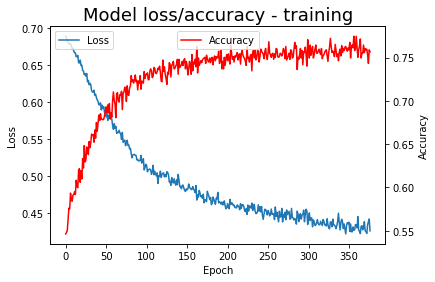

<Figure size 432x288 with 0 Axes>

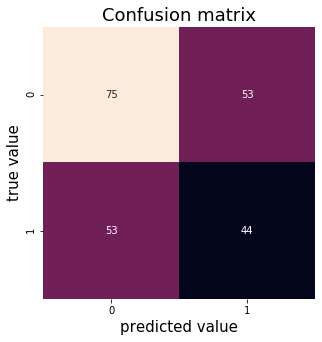

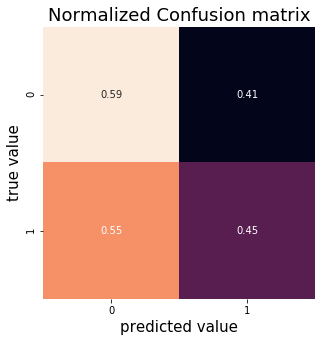

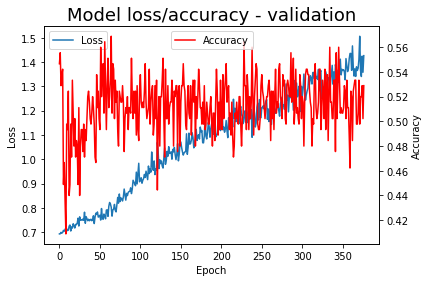

              precision    recall  f1-score   support

           0       0.59      0.59      0.59       128
           1       0.45      0.45      0.45        97

    accuracy                           0.53       225
   macro avg       0.52      0.52      0.52       225
weighted avg       0.53      0.53      0.53       225



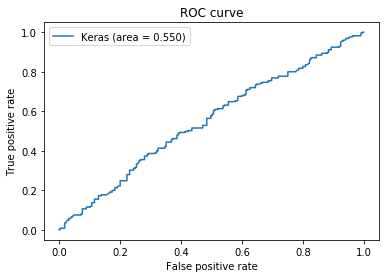

In [28]:
evaluate_mode(model)

***
## Regularization



    Let us see if a Dropout could lead to a better generalization. A dropout layer is added. Here we were experimenting with different amount of dropout layers and also adding dropout in the recurrent layer.
   


#### Let us define a new Recurrent Neural Network


Input shape 1274
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 16)                288       
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 18        
Total params: 586
Trainable params: 586
Non-trainable params: 0
_______________________________________

Epoch 75/200
 - 0s - loss: 0.6783 - accuracy: 0.5761 - val_loss: 0.6941 - val_accuracy: 0.5422
Epoch 76/200
 - 0s - loss: 0.6808 - accuracy: 0.5683 - val_loss: 0.6964 - val_accuracy: 0.5289
Epoch 77/200
 - 0s - loss: 0.6839 - accuracy: 0.5510 - val_loss: 0.6936 - val_accuracy: 0.5378
Epoch 78/200
 - 0s - loss: 0.6849 - accuracy: 0.5471 - val_loss: 0.6955 - val_accuracy: 0.5378
Epoch 79/200
 - 0s - loss: 0.6811 - accuracy: 0.5644 - val_loss: 0.6972 - val_accuracy: 0.5556
Epoch 80/200
 - 0s - loss: 0.6801 - accuracy: 0.5604 - val_loss: 0.6965 - val_accuracy: 0.5556
Epoch 81/200
 - 0s - loss: 0.6838 - accuracy: 0.5542 - val_loss: 0.6958 - val_accuracy: 0.5244
Epoch 82/200
 - 0s - loss: 0.6813 - accuracy: 0.5620 - val_loss: 0.6941 - val_accuracy: 0.5511
Epoch 83/200
 - 0s - loss: 0.6853 - accuracy: 0.5620 - val_loss: 0.6939 - val_accuracy: 0.5378
Epoch 84/200
 - 0s - loss: 0.6831 - accuracy: 0.5604 - val_loss: 0.6947 - val_accuracy: 0.5467
Epoch 85/200
 - 0s - loss: 0.6821 - accuracy: 0.55

Epoch 161/200
 - 0s - loss: 0.6743 - accuracy: 0.5754 - val_loss: 0.7136 - val_accuracy: 0.4800
Epoch 162/200
 - 0s - loss: 0.6775 - accuracy: 0.5683 - val_loss: 0.7163 - val_accuracy: 0.4889
Epoch 163/200
 - 0s - loss: 0.6739 - accuracy: 0.5879 - val_loss: 0.7212 - val_accuracy: 0.4756
Epoch 164/200
 - 0s - loss: 0.6752 - accuracy: 0.5863 - val_loss: 0.7205 - val_accuracy: 0.4756
Epoch 165/200
 - 0s - loss: 0.6788 - accuracy: 0.5636 - val_loss: 0.7122 - val_accuracy: 0.5022
Epoch 166/200
 - 0s - loss: 0.6780 - accuracy: 0.5801 - val_loss: 0.7119 - val_accuracy: 0.5067
Epoch 167/200
 - 0s - loss: 0.6713 - accuracy: 0.5871 - val_loss: 0.7157 - val_accuracy: 0.4844
Epoch 168/200
 - 0s - loss: 0.6743 - accuracy: 0.5808 - val_loss: 0.7145 - val_accuracy: 0.4756
Epoch 169/200
 - 0s - loss: 0.6781 - accuracy: 0.5675 - val_loss: 0.7151 - val_accuracy: 0.4667
Epoch 170/200
 - 0s - loss: 0.6737 - accuracy: 0.5934 - val_loss: 0.7143 - val_accuracy: 0.4756
Epoch 171/200
 - 0s - loss: 0.6747 - acc

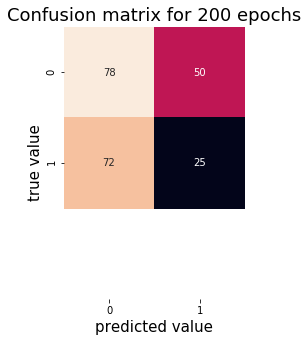

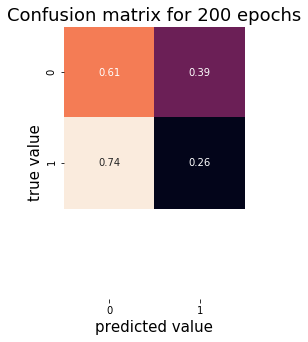

In [31]:


history = None


def create_and_run_RNN_drp(ep):
        model = Sequential()
  
        model.add(SimpleRNN(16,  recurrent_dropout=0.2, input_shape=(None, 1)))
        #model.add(SimpleRNN(16, dropout=(None, 1)))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(8, activation='relu'))

            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        print("Input shape {}".format(len(X_train)))
        model.summary()
       
        ##Regularization
        monitor = EarlyStopping(monitor='loss', min_delta=1e-10, patience=30, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=10, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        ##Precision and recall
        #F1 score
        #error rate
        #ROC curve
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epoch's test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_drp(200) 

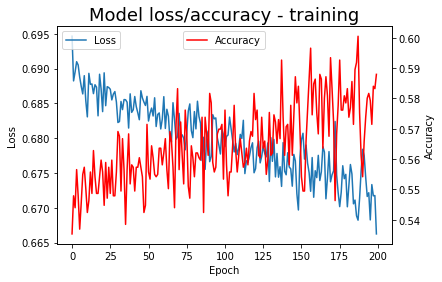

<Figure size 432x288 with 0 Axes>

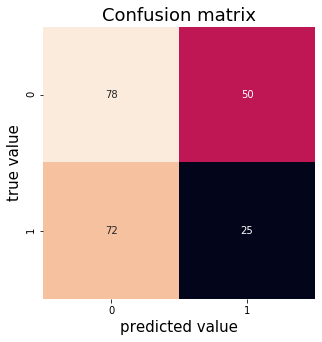

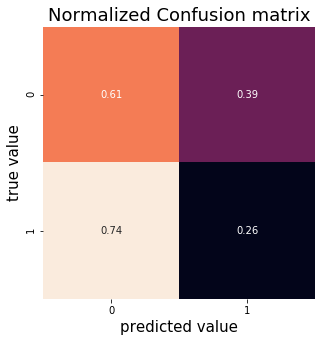

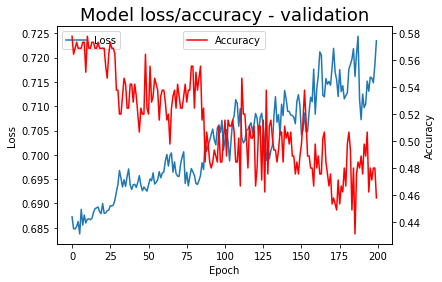

              precision    recall  f1-score   support

           0       0.52      0.61      0.56       128
           1       0.33      0.26      0.29        97

    accuracy                           0.46       225
   macro avg       0.43      0.43      0.43       225
weighted avg       0.44      0.46      0.44       225



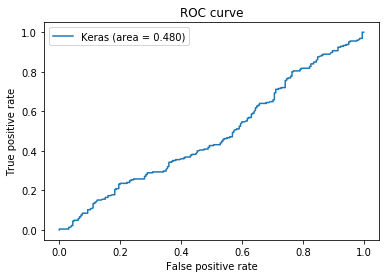

In [32]:
evaluate_mode(model)

***

### L1 (Lasso)  and L2 (Ridge) regularizer

Let us try to add L1 and L2 Regulators.

L1 Regularization, also called LASSO (Least Absolute Shrinkage and Selection Operator) will prevent overfitting by creating sparsity. It does so by penalizing different weights and pushing them near 0. When the connection is near 0 the network drops it. The idea is that it will eliminate features that do not help the network generalize.

L2 also keeps the weight small by penalizing the different weights, but it does so by forcing the weights into a gaussian distrbution. 

L1 and L2 can be added as kernel- or -activity regularizer in Keras

Input shape 1274
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_35 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_36 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_37 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_38 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 34        
Total params: 5,730
Trainable params: 5,730
Non-trainable params: 0
__________________________________

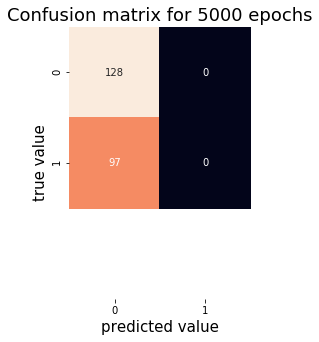

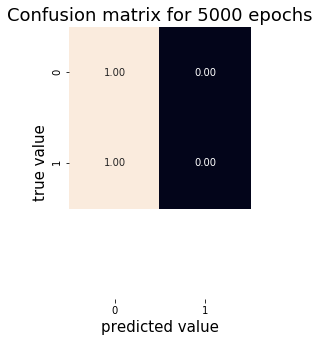

In [34]:
from keras import regularizers
#kernel_regularizer=regularizers.l1(0.01))

history = None

def create_and_run_RNN_drp(ep):
        model = Sequential()
  
        model.add(LSTM(32, input_shape=(None, 1)))
        model.add(Dense(16, activation='relu',  kernel_regularizer=regularizers.l1(0.01)))
        model.add(Dense(16, activation='relu',  activity_regularizer=regularizers.l2(0.01)))
        model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01), 
                        activity_regularizer=regularizers.l1(0.01)))
        model.add(Dense(16, activation='relu',  kernel_regularizer=regularizers.l1(0.01)))
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        print("Input shape {}".format(len(X_train)))
        model.summary()
       
      
        ##Regularization
        monitor = EarlyStopping(monitor='loss', min_delta=1e-10, patience=30, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, callbacks=[monitor],validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_drp(5000) 

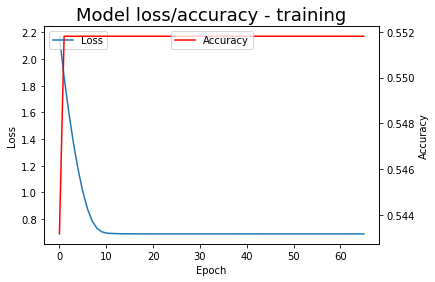

<Figure size 432x288 with 0 Axes>

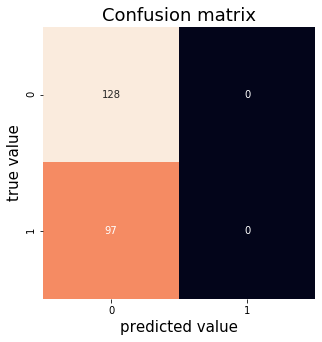

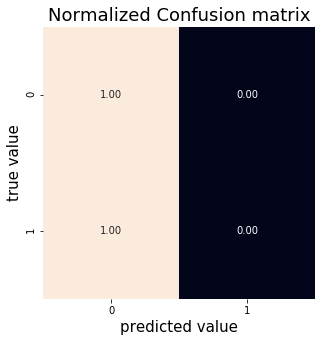

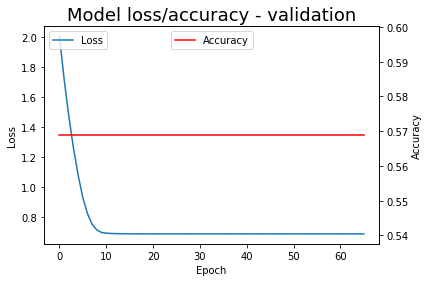

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       128
           1       0.00      0.00      0.00        97

    accuracy                           0.57       225
   macro avg       0.28      0.50      0.36       225
weighted avg       0.32      0.57      0.41       225



/home/douglas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


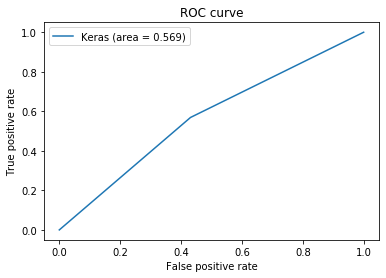

In [35]:
evaluate_mode(model)

## Only L1

Input shape 1274
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_41 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 18        
Total params: 1,378
Trainable params: 1,378
Non-trainable params: 0
_________________________________________________________________
Train on 1274 samples, validate on 225 samples
Epoch 1/400
 - 1s - loss: 0.8848 - accuracy: 0.5471 - val_loss: 0.8696 - val_accuracy: 0.5689
Epoch 2/400
 - 0s - loss: 0.8587 - accuracy: 0.5518 - val_loss: 0.8438 - val_accuracy: 0.56

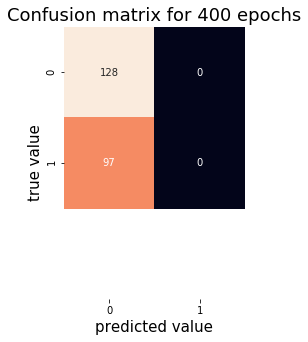

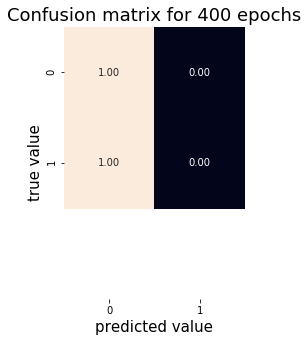

In [37]:
from keras import regularizers
#kernel_regularizer=regularizers.l1(0.01))

history = None

def create_and_run_RNN_drp(ep):
        model = Sequential()
  
        model.add(LSTM(16, input_shape=(None, 1)))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu',  kernel_regularizer=regularizers.l1(0.01)))
       # model.add(Dense(32, activation='relu'))
       # model.add(Dense(32, activation='relu'))

            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        print("Input shape {}".format(len(X_train)))
        model.summary()
       
        ##Regularization
        monitor = EarlyStopping(monitor='loss', min_delta=1e-12, patience=30, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, callbacks=[monitor], validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_drp(400) 
#  That's most likely because it still tries to check for 'stable' label.}

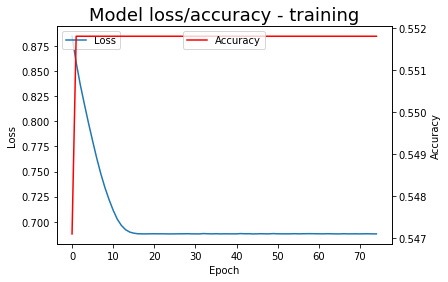

<Figure size 432x288 with 0 Axes>

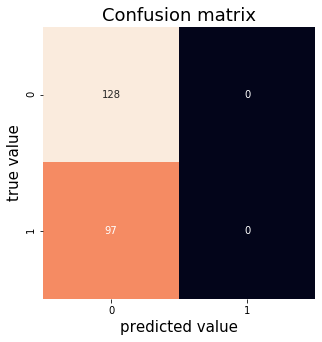

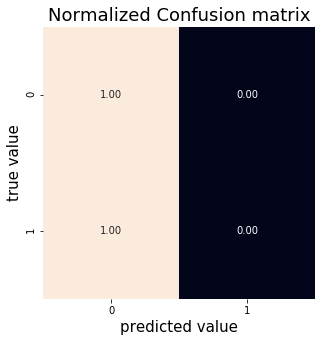

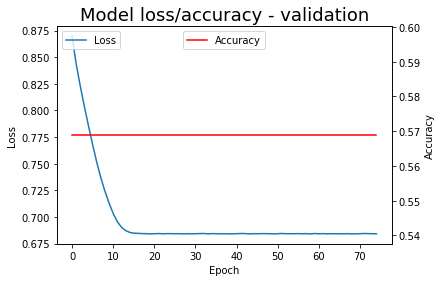

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       128
           1       0.00      0.00      0.00        97

    accuracy                           0.57       225
   macro avg       0.28      0.50      0.36       225
weighted avg       0.32      0.57      0.41       225



/home/douglas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


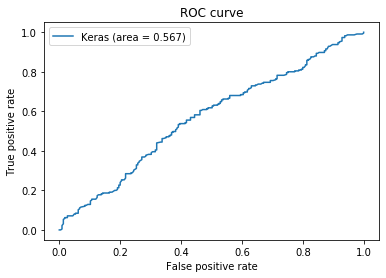

In [38]:
evaluate_mode(model)

So it can not fit the traiing data with this L1 implementation. 

***

## Only L2

Input shape 1274
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 16)                288       
_________________________________________________________________
dense_43 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 18        
Total params: 514
Trainable params: 514
Non-trainable params: 0
_________________________________________________________________
Train on 1274 samples, validate on 225 samples
Epoch 1/200
 - 1s - loss: 1.2741 - accuracy: 0.5510 - val_loss: 1.0982 - val_accuracy: 0.5778
Epoch 2/200
 - 0s - loss: 0.9942 - accuracy: 0.5518 - val_loss: 0.9016 - val_accuracy: 0.5689
E

Epoch 78/200
 - 0s - loss: 0.6291 - accuracy: 0.6499 - val_loss: 0.8063 - val_accuracy: 0.4622
Epoch 79/200
 - 0s - loss: 0.6296 - accuracy: 0.6452 - val_loss: 0.7962 - val_accuracy: 0.4578
Epoch 80/200
 - 0s - loss: 0.6303 - accuracy: 0.6531 - val_loss: 0.7977 - val_accuracy: 0.4933
Epoch 81/200
 - 0s - loss: 0.6276 - accuracy: 0.6562 - val_loss: 0.7970 - val_accuracy: 0.4933
Epoch 82/200
 - 0s - loss: 0.6263 - accuracy: 0.6617 - val_loss: 0.8152 - val_accuracy: 0.4844
Epoch 83/200
 - 0s - loss: 0.6256 - accuracy: 0.6578 - val_loss: 0.7961 - val_accuracy: 0.4489
Epoch 84/200
 - 0s - loss: 0.6255 - accuracy: 0.6664 - val_loss: 0.7906 - val_accuracy: 0.4711
Epoch 85/200
 - 1s - loss: 0.6230 - accuracy: 0.6586 - val_loss: 0.7961 - val_accuracy: 0.4933
Epoch 86/200
 - 0s - loss: 0.6219 - accuracy: 0.6633 - val_loss: 0.8068 - val_accuracy: 0.4844
Epoch 87/200
 - 0s - loss: 0.6232 - accuracy: 0.6601 - val_loss: 0.7866 - val_accuracy: 0.4889
Epoch 88/200
 - 0s - loss: 0.6194 - accuracy: 0.66

Epoch 164/200
 - 0s - loss: 0.5687 - accuracy: 0.7017 - val_loss: 0.8657 - val_accuracy: 0.4889
Epoch 165/200
 - 0s - loss: 0.5688 - accuracy: 0.7017 - val_loss: 0.8965 - val_accuracy: 0.5022
Epoch 166/200
 - 0s - loss: 0.5642 - accuracy: 0.6978 - val_loss: 0.9031 - val_accuracy: 0.5067
Epoch 167/200
 - 0s - loss: 0.5679 - accuracy: 0.7080 - val_loss: 0.8738 - val_accuracy: 0.5378
Epoch 168/200
 - 0s - loss: 0.5670 - accuracy: 0.7064 - val_loss: 0.8724 - val_accuracy: 0.5156
Epoch 169/200
 - 0s - loss: 0.5646 - accuracy: 0.7080 - val_loss: 0.8963 - val_accuracy: 0.5200
Epoch 170/200
 - 0s - loss: 0.5629 - accuracy: 0.7088 - val_loss: 0.8857 - val_accuracy: 0.5111
Epoch 171/200
 - 0s - loss: 0.5669 - accuracy: 0.7088 - val_loss: 0.9157 - val_accuracy: 0.4889
Epoch 172/200
 - 0s - loss: 0.5649 - accuracy: 0.7041 - val_loss: 0.8875 - val_accuracy: 0.5244
Epoch 173/200
 - 0s - loss: 0.5620 - accuracy: 0.7064 - val_loss: 0.9143 - val_accuracy: 0.5156
Epoch 174/200
 - 0s - loss: 0.5669 - acc

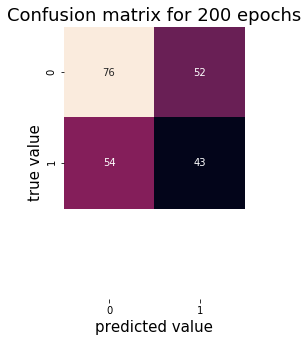

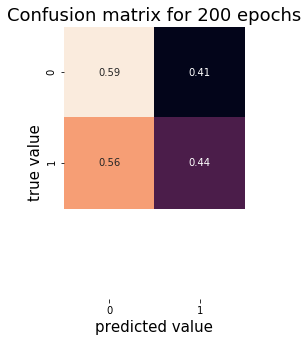

In [40]:
from keras import regularizers
#kernel_regularizer=regularizers.l1(0.01))

history = None

def create_and_run_RNN_L2(ep):
        model = Sequential()
  
        model.add(SimpleRNN(16, input_shape=(None, 1)))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu',  kernel_regularizer=regularizers.l2(0.1)))
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        print("Input shape {}".format(len(X_train)))
        model.summary()
        ##Regularization
        monitor = EarlyStopping(monitor='loss', min_delta=1e-10, patience=30, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, callbacks=[monitor],batch_size=10, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        ##Precision and recall
        #F1 score
        #error rate
        #ROC curve
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_L2(200) 


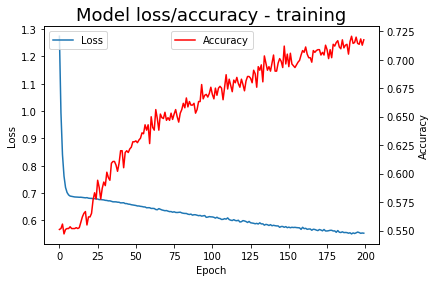

<Figure size 432x288 with 0 Axes>

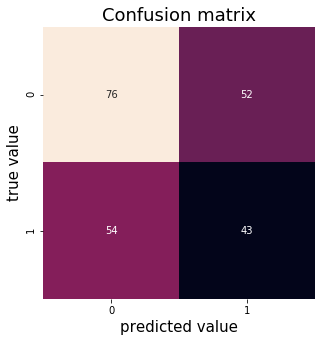

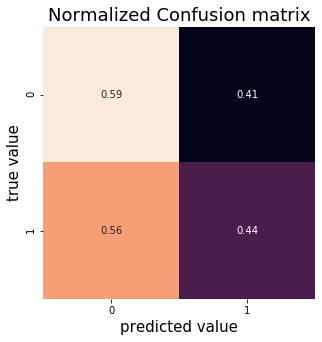

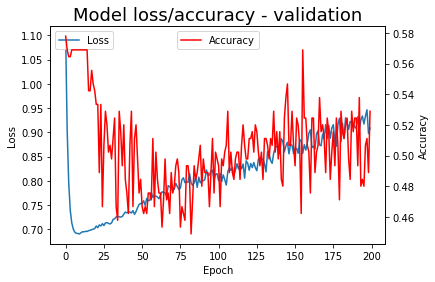

              precision    recall  f1-score   support

           0       0.58      0.59      0.59       128
           1       0.45      0.44      0.45        97

    accuracy                           0.53       225
   macro avg       0.52      0.52      0.52       225
weighted avg       0.53      0.53      0.53       225



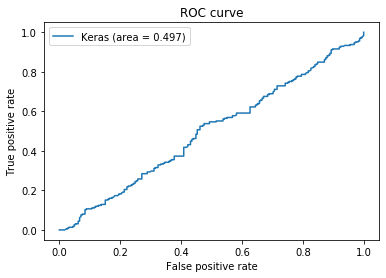

In [41]:
evaluate_mode(model)

**So the model can not fit the training data with this L2 implementation. As soon as the loss of the training starts to drop the validation loss is increasing.**

## Different Sequence Length

## 3

In [ ]:
## 3

SEQUENCE_SIZE = 3
X,y = to_sequences(SEQUENCE_SIZE, dailyChanges)

y = to_categorical(y) #Hot encode it

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)


history = None

def create_and_run_RNN_different_sequence( ep ):
        model = Sequential()
        model.add(SimpleRNN(16, input_shape=(None, 1)))
     
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu'))
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        model.summary()
  
        ##Regularization
        #monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=10, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        ##Precision and recall
    
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_different_sequence(200) #Run with 200 epochs and the default RNN layer that is SimpleRNN



dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


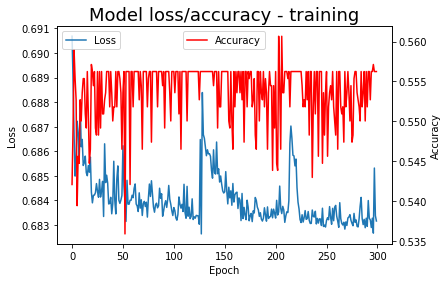

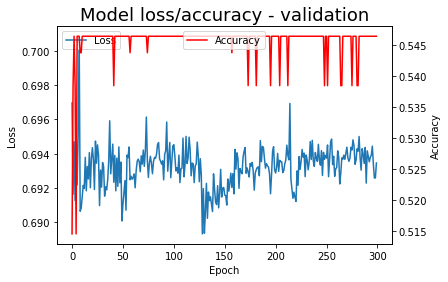

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 

/home/douglas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


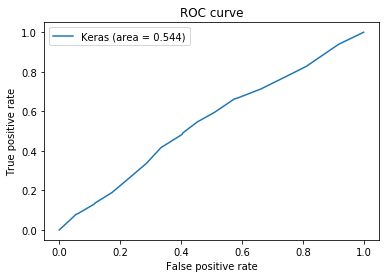

In [88]:
evaluate_mode(model)

## Sequence 14

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, 64)                4224      
_________________________________________________________________
dense_78 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_79 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_80 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_81 (Dense)             (None, 2)                 66        
Total params: 8,482
Trainable params: 8,482
Non-trainable params: 0
_________________________________________________________________
Train on 1121 samples, validate on 374 samples
Epoch 1/200
 - 1s - loss: 0.6943 - accuracy: 0.5210 - val_loss: 0.6904

Epoch 77/200
 - 0s - loss: 0.1504 - accuracy: 0.9367 - val_loss: 2.6094 - val_accuracy: 0.4920
Epoch 78/200
 - 0s - loss: 0.1327 - accuracy: 0.9474 - val_loss: 2.4577 - val_accuracy: 0.4973
Epoch 79/200
 - 0s - loss: 0.1073 - accuracy: 0.9563 - val_loss: 2.4347 - val_accuracy: 0.5107
Epoch 80/200
 - 0s - loss: 0.1032 - accuracy: 0.9527 - val_loss: 2.5809 - val_accuracy: 0.5134
Epoch 81/200
 - 0s - loss: 0.1074 - accuracy: 0.9572 - val_loss: 2.4826 - val_accuracy: 0.5134
Epoch 82/200
 - 0s - loss: 0.1006 - accuracy: 0.9625 - val_loss: 2.5711 - val_accuracy: 0.5160
Epoch 83/200
 - 0s - loss: 0.0878 - accuracy: 0.9643 - val_loss: 2.6865 - val_accuracy: 0.5160
Epoch 84/200
 - 0s - loss: 0.0778 - accuracy: 0.9706 - val_loss: 2.5787 - val_accuracy: 0.5080
Epoch 85/200
 - 0s - loss: 0.0791 - accuracy: 0.9679 - val_loss: 2.5487 - val_accuracy: 0.5027
Epoch 86/200
 - 0s - loss: 0.1213 - accuracy: 0.9500 - val_loss: 2.6134 - val_accuracy: 0.5107
Epoch 87/200
 - 0s - loss: 0.1238 - accuracy: 0.94

Epoch 163/200
 - 0s - loss: 0.0874 - accuracy: 0.9581 - val_loss: 2.7640 - val_accuracy: 0.4947
Epoch 164/200
 - 0s - loss: 0.2983 - accuracy: 0.8947 - val_loss: 2.5374 - val_accuracy: 0.4759
Epoch 165/200
 - 0s - loss: 0.1333 - accuracy: 0.9420 - val_loss: 2.6144 - val_accuracy: 0.5187
Epoch 166/200
 - 0s - loss: 0.0817 - accuracy: 0.9581 - val_loss: 2.7381 - val_accuracy: 0.4973
Epoch 167/200
 - 0s - loss: 0.0557 - accuracy: 0.9741 - val_loss: 2.7845 - val_accuracy: 0.4866
Epoch 168/200
 - 0s - loss: 0.0503 - accuracy: 0.9679 - val_loss: 2.8886 - val_accuracy: 0.4813
Epoch 169/200
 - 0s - loss: 0.0599 - accuracy: 0.9706 - val_loss: 2.8656 - val_accuracy: 0.5000
Epoch 170/200
 - 0s - loss: 0.0491 - accuracy: 0.9679 - val_loss: 2.9235 - val_accuracy: 0.5027
Epoch 171/200
 - 0s - loss: 0.0472 - accuracy: 0.9715 - val_loss: 2.9444 - val_accuracy: 0.5027
Epoch 172/200
 - 0s - loss: 0.0480 - accuracy: 0.9670 - val_loss: 2.9878 - val_accuracy: 0.5080
Epoch 173/200
 - 0s - loss: 0.0453 - acc

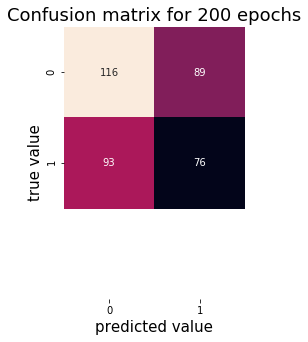

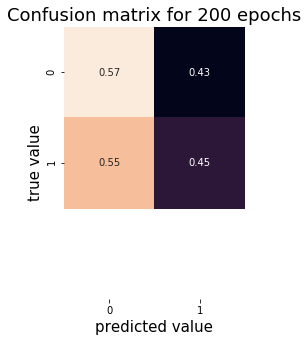

In [92]:
## 3

dailyChanges = pd.read_csv('./preprocessing/all_pricesAverages.csv')

SEQUENCE_SIZE = 14
X,y = to_sequences(SEQUENCE_SIZE, dailyChanges)

y = to_categorical(y) #Hot encode it

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

history = None


def create_and_run_RNN_different_sequence( ep ):
        model = Sequential()
        model.add(SimpleRNN(16, input_shape=(None, 1)))
     
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu'))
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        model.summary()
   
        ##Regularization
        #monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=10, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        ##Precision and recall
    
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_different_sequence(200) #Run with 200 epochs and the default RNN layer that is SimpleRNN



dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


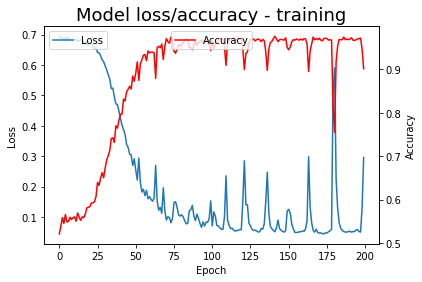

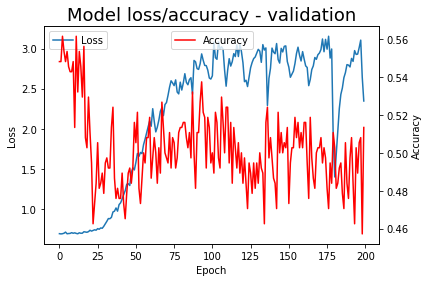

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 

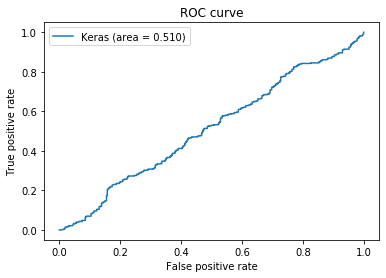

In [93]:
evaluate_mode(model)

## Overfits with larger sequence and 10 in batch size

### Sequence 5

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_17 (SimpleRNN)    (None, 64)                4224      
_________________________________________________________________
dense_82 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_83 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_84 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_85 (Dense)             (None, 2)                 66        
Total params: 8,482
Trainable params: 8,482
Non-trainable params: 0
_________________________________________________________________
Train on 1121 samples, validate on 374 samples
Epoch 1/200
 - 2s - loss: 0.6970 - accuracy: 0.5219 - val_loss: 0.6860

Epoch 77/200
 - 1s - loss: 0.1276 - accuracy: 0.9420 - val_loss: 2.7495 - val_accuracy: 0.4652
Epoch 78/200
 - 1s - loss: 0.1431 - accuracy: 0.9447 - val_loss: 2.7084 - val_accuracy: 0.4465
Epoch 79/200
 - 1s - loss: 0.1351 - accuracy: 0.9447 - val_loss: 2.7030 - val_accuracy: 0.4920
Epoch 80/200
 - 1s - loss: 0.1025 - accuracy: 0.9607 - val_loss: 2.6276 - val_accuracy: 0.4733
Epoch 81/200
 - 1s - loss: 0.0606 - accuracy: 0.9750 - val_loss: 2.8913 - val_accuracy: 0.4679
Epoch 82/200
 - 1s - loss: 0.0662 - accuracy: 0.9706 - val_loss: 2.8430 - val_accuracy: 0.4813
Epoch 83/200
 - 1s - loss: 0.0681 - accuracy: 0.9723 - val_loss: 3.0707 - val_accuracy: 0.4385
Epoch 84/200
 - 1s - loss: 0.0865 - accuracy: 0.9652 - val_loss: 2.8886 - val_accuracy: 0.4706
Epoch 85/200
 - 1s - loss: 0.4113 - accuracy: 0.8421 - val_loss: 2.1817 - val_accuracy: 0.4385
Epoch 86/200
 - 1s - loss: 0.1730 - accuracy: 0.9215 - val_loss: 2.3666 - val_accuracy: 0.4439
Epoch 87/200
 - 1s - loss: 0.0923 - accuracy: 0.95

Epoch 163/200
 - 1s - loss: 0.0521 - accuracy: 0.9768 - val_loss: 2.7164 - val_accuracy: 0.4572
Epoch 164/200
 - 1s - loss: 0.0448 - accuracy: 0.9732 - val_loss: 2.8153 - val_accuracy: 0.4572
Epoch 165/200
 - 1s - loss: 0.0403 - accuracy: 0.9786 - val_loss: 2.8863 - val_accuracy: 0.4545
Epoch 166/200
 - 1s - loss: 0.0388 - accuracy: 0.9759 - val_loss: 2.9821 - val_accuracy: 0.4572
Epoch 167/200
 - 1s - loss: 0.0909 - accuracy: 0.9572 - val_loss: 2.9169 - val_accuracy: 0.4813
Epoch 168/200
 - 1s - loss: 0.0926 - accuracy: 0.9625 - val_loss: 2.7489 - val_accuracy: 0.4813
Epoch 169/200
 - 1s - loss: 0.2442 - accuracy: 0.9090 - val_loss: 2.1474 - val_accuracy: 0.4947
Epoch 170/200
 - 1s - loss: 0.1496 - accuracy: 0.9304 - val_loss: 2.4558 - val_accuracy: 0.4840
Epoch 171/200
 - 1s - loss: 0.1120 - accuracy: 0.9625 - val_loss: 2.4152 - val_accuracy: 0.4759
Epoch 172/200
 - 1s - loss: 0.0625 - accuracy: 0.9715 - val_loss: 2.7038 - val_accuracy: 0.4626
Epoch 173/200
 - 1s - loss: 0.0462 - acc

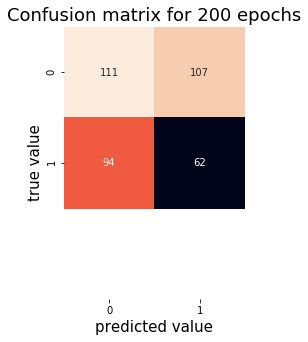

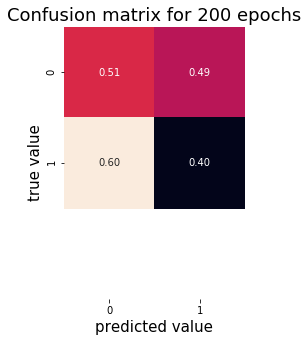

In [94]:
## 3

dailyChanges = pd.read_csv('./preprocessing/all_pricesAverages.csv')

SEQUENCE_SIZE = 14
X,y = to_sequences(SEQUENCE_SIZE, dailyChanges)

y = to_categorical(y) #Hot encode it

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)




history = None


def create_and_run_RNN_different_sequence( ep ):
        model = Sequential()
        model.add(Sim(64, input_shape=(None, 1)))
     
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        model.summary()
  
        ##Regularization
        #monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=5, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        ##Precision and recall
    
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_different_sequence(200) #Run with 200 epochs and the defauly RNN layer that is SimpleRNN



dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


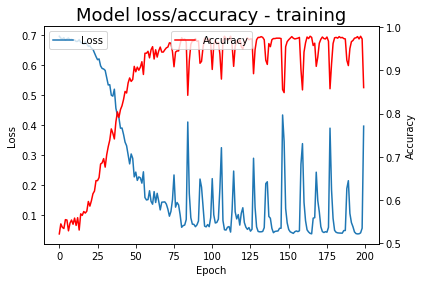

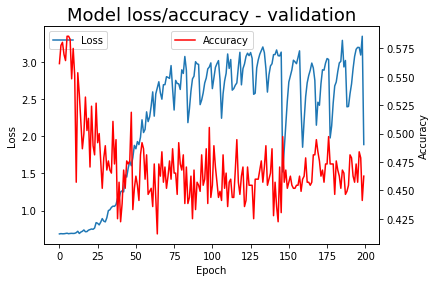

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 

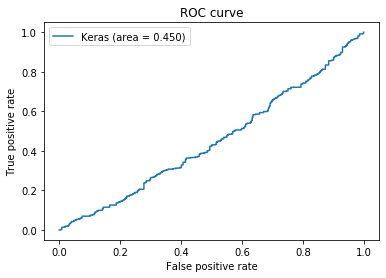

In [95]:
evaluate_mode(model)

## Sequence 8

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 16)                288       
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 18        
Total params: 514
Trainable params: 514
Non-trainable params: 0
_________________________________________________________________
Train on 1125 samples, validate on 376 samples
Epoch 1/1000
 - 1s - loss: 0.6928 - accuracy: 0.5476 - val_loss: 0.6871 - val_accuracy: 0.5426
Epoch 2/1000
 - 0s - loss: 0.6875 - accuracy: 0.5360 - val_loss: 0.6845 - val_accuracy: 0.5798
Epoch 3/1000
 - 0

Epoch 77/1000
 - 0s - loss: 0.6384 - accuracy: 0.6329 - val_loss: 0.7390 - val_accuracy: 0.4867
Epoch 78/1000
 - 0s - loss: 0.6307 - accuracy: 0.6338 - val_loss: 0.7525 - val_accuracy: 0.5106
Epoch 79/1000
 - 0s - loss: 0.6348 - accuracy: 0.6284 - val_loss: 0.7277 - val_accuracy: 0.5239
Epoch 80/1000
 - 0s - loss: 0.6337 - accuracy: 0.6418 - val_loss: 0.7328 - val_accuracy: 0.5106
Epoch 81/1000
 - 0s - loss: 0.6365 - accuracy: 0.6293 - val_loss: 0.7351 - val_accuracy: 0.4867
Epoch 82/1000
 - 0s - loss: 0.6339 - accuracy: 0.6258 - val_loss: 0.7344 - val_accuracy: 0.5213
Epoch 83/1000
 - 0s - loss: 0.6353 - accuracy: 0.6356 - val_loss: 0.7398 - val_accuracy: 0.5027
Epoch 84/1000
 - 0s - loss: 0.6305 - accuracy: 0.6444 - val_loss: 0.7367 - val_accuracy: 0.5106
Epoch 85/1000
 - 0s - loss: 0.6339 - accuracy: 0.6293 - val_loss: 0.7433 - val_accuracy: 0.5000
Epoch 86/1000
 - 0s - loss: 0.6310 - accuracy: 0.6356 - val_loss: 0.7253 - val_accuracy: 0.4867
Epoch 87/1000
 - 0s - loss: 0.6312 - acc

Epoch 162/1000
 - 0s - loss: 0.6179 - accuracy: 0.6604 - val_loss: 0.7454 - val_accuracy: 0.5160
Epoch 163/1000
 - 1s - loss: 0.6202 - accuracy: 0.6533 - val_loss: 0.7541 - val_accuracy: 0.5213
Epoch 164/1000
 - 1s - loss: 0.6159 - accuracy: 0.6542 - val_loss: 0.7586 - val_accuracy: 0.4947
Epoch 165/1000
 - 0s - loss: 0.6159 - accuracy: 0.6524 - val_loss: 0.7391 - val_accuracy: 0.5319
Epoch 166/1000
 - 0s - loss: 0.6151 - accuracy: 0.6560 - val_loss: 0.7719 - val_accuracy: 0.4867
Epoch 167/1000
 - 0s - loss: 0.6155 - accuracy: 0.6453 - val_loss: 0.7705 - val_accuracy: 0.5160
Epoch 168/1000
 - 0s - loss: 0.6142 - accuracy: 0.6613 - val_loss: 0.7647 - val_accuracy: 0.4947
Epoch 169/1000
 - 0s - loss: 0.6145 - accuracy: 0.6578 - val_loss: 0.7530 - val_accuracy: 0.5319
Epoch 170/1000
 - 0s - loss: 0.6146 - accuracy: 0.6613 - val_loss: 0.7687 - val_accuracy: 0.5000
Epoch 171/1000
 - 0s - loss: 0.6133 - accuracy: 0.6640 - val_loss: 0.7778 - val_accuracy: 0.5027
Epoch 172/1000
 - 0s - loss: 0

Epoch 247/1000
 - 0s - loss: 0.6082 - accuracy: 0.6596 - val_loss: 0.7777 - val_accuracy: 0.5133
Epoch 248/1000
 - 0s - loss: 0.6123 - accuracy: 0.6436 - val_loss: 0.7677 - val_accuracy: 0.5186
Epoch 249/1000
 - 0s - loss: 0.6093 - accuracy: 0.6418 - val_loss: 0.7718 - val_accuracy: 0.5133
Epoch 250/1000
 - 1s - loss: 0.6064 - accuracy: 0.6631 - val_loss: 0.7746 - val_accuracy: 0.5213
Epoch 251/1000
 - 1s - loss: 0.6110 - accuracy: 0.6471 - val_loss: 0.7747 - val_accuracy: 0.5160
Epoch 252/1000
 - 1s - loss: 0.6016 - accuracy: 0.6596 - val_loss: 0.7726 - val_accuracy: 0.5319
Epoch 253/1000
 - 0s - loss: 0.6069 - accuracy: 0.6578 - val_loss: 0.7779 - val_accuracy: 0.5186
Epoch 254/1000
 - 0s - loss: 0.6107 - accuracy: 0.6498 - val_loss: 0.7565 - val_accuracy: 0.5160
Epoch 255/1000
 - 0s - loss: 0.6097 - accuracy: 0.6462 - val_loss: 0.7701 - val_accuracy: 0.5133
Epoch 256/1000
 - 1s - loss: 0.6038 - accuracy: 0.6524 - val_loss: 0.7707 - val_accuracy: 0.5160
Epoch 257/1000
 - 0s - loss: 0

Epoch 332/1000
 - 0s - loss: 0.5981 - accuracy: 0.6613 - val_loss: 0.7948 - val_accuracy: 0.5160
Epoch 333/1000
 - 0s - loss: 0.5975 - accuracy: 0.6720 - val_loss: 0.7888 - val_accuracy: 0.5160
Epoch 334/1000
 - 0s - loss: 0.6001 - accuracy: 0.6622 - val_loss: 0.7934 - val_accuracy: 0.5266
Epoch 335/1000
 - 1s - loss: 0.5993 - accuracy: 0.6667 - val_loss: 0.7891 - val_accuracy: 0.5027
Epoch 336/1000
 - 0s - loss: 0.5988 - accuracy: 0.6507 - val_loss: 0.7921 - val_accuracy: 0.5213
Epoch 337/1000
 - 1s - loss: 0.5983 - accuracy: 0.6551 - val_loss: 0.7928 - val_accuracy: 0.5027
Epoch 338/1000
 - 0s - loss: 0.5936 - accuracy: 0.6702 - val_loss: 0.8217 - val_accuracy: 0.5266
Epoch 339/1000
 - 1s - loss: 0.6009 - accuracy: 0.6551 - val_loss: 0.8111 - val_accuracy: 0.5053
Epoch 340/1000
 - 1s - loss: 0.6001 - accuracy: 0.6604 - val_loss: 0.7923 - val_accuracy: 0.5266
Epoch 341/1000
 - 1s - loss: 0.5984 - accuracy: 0.6640 - val_loss: 0.7821 - val_accuracy: 0.5479
Epoch 342/1000
 - 1s - loss: 0

Epoch 417/1000
 - 0s - loss: 0.5940 - accuracy: 0.6640 - val_loss: 0.8071 - val_accuracy: 0.4973
Epoch 418/1000
 - 0s - loss: 0.5939 - accuracy: 0.6667 - val_loss: 0.8039 - val_accuracy: 0.5027
Epoch 419/1000
 - 0s - loss: 0.5981 - accuracy: 0.6622 - val_loss: 0.8078 - val_accuracy: 0.5319
Epoch 420/1000
 - 0s - loss: 0.5920 - accuracy: 0.6578 - val_loss: 0.8206 - val_accuracy: 0.4947
Epoch 421/1000
 - 0s - loss: 0.5946 - accuracy: 0.6702 - val_loss: 0.8117 - val_accuracy: 0.5053
Epoch 422/1000
 - 0s - loss: 0.5921 - accuracy: 0.6658 - val_loss: 0.8223 - val_accuracy: 0.5027
Epoch 423/1000
 - 0s - loss: 0.5975 - accuracy: 0.6507 - val_loss: 0.7920 - val_accuracy: 0.5186
Epoch 424/1000
 - 0s - loss: 0.5967 - accuracy: 0.6596 - val_loss: 0.8552 - val_accuracy: 0.4867
Epoch 425/1000
 - 0s - loss: 0.6009 - accuracy: 0.6524 - val_loss: 0.8050 - val_accuracy: 0.5319
Epoch 426/1000
 - 0s - loss: 0.5934 - accuracy: 0.6560 - val_loss: 0.8177 - val_accuracy: 0.5186
Epoch 427/1000
 - 0s - loss: 0

Epoch 502/1000
 - 0s - loss: 0.5914 - accuracy: 0.6587 - val_loss: 0.8030 - val_accuracy: 0.5080
Epoch 503/1000
 - 0s - loss: 0.5962 - accuracy: 0.6649 - val_loss: 0.8173 - val_accuracy: 0.5186
Epoch 504/1000
 - 0s - loss: 0.5916 - accuracy: 0.6658 - val_loss: 0.8385 - val_accuracy: 0.5027
Epoch 505/1000
 - 0s - loss: 0.5901 - accuracy: 0.6658 - val_loss: 0.8187 - val_accuracy: 0.5133
Epoch 506/1000
 - 0s - loss: 0.5930 - accuracy: 0.6587 - val_loss: 0.8245 - val_accuracy: 0.5053
Epoch 507/1000
 - 0s - loss: 0.5940 - accuracy: 0.6604 - val_loss: 0.8185 - val_accuracy: 0.5266
Epoch 508/1000
 - 0s - loss: 0.5900 - accuracy: 0.6596 - val_loss: 0.8105 - val_accuracy: 0.5319
Epoch 509/1000
 - 0s - loss: 0.5918 - accuracy: 0.6631 - val_loss: 0.8398 - val_accuracy: 0.5027
Epoch 510/1000
 - 0s - loss: 0.5929 - accuracy: 0.6658 - val_loss: 0.8168 - val_accuracy: 0.5027
Epoch 511/1000
 - 0s - loss: 0.5917 - accuracy: 0.6667 - val_loss: 0.8125 - val_accuracy: 0.5213
Epoch 512/1000
 - 0s - loss: 0

Epoch 587/1000
 - 0s - loss: 0.5920 - accuracy: 0.6578 - val_loss: 0.8262 - val_accuracy: 0.5000
Epoch 588/1000
 - 0s - loss: 0.5917 - accuracy: 0.6622 - val_loss: 0.8127 - val_accuracy: 0.5213
Epoch 589/1000
 - 0s - loss: 0.5959 - accuracy: 0.6542 - val_loss: 0.8232 - val_accuracy: 0.5027
Epoch 590/1000
 - 0s - loss: 0.5920 - accuracy: 0.6453 - val_loss: 0.8177 - val_accuracy: 0.5399
Epoch 591/1000
 - 0s - loss: 0.5922 - accuracy: 0.6604 - val_loss: 0.8370 - val_accuracy: 0.4840
Epoch 592/1000
 - 0s - loss: 0.5892 - accuracy: 0.6587 - val_loss: 0.8600 - val_accuracy: 0.4947
Epoch 593/1000
 - 0s - loss: 0.5928 - accuracy: 0.6542 - val_loss: 0.8406 - val_accuracy: 0.4894
Epoch 594/1000
 - 0s - loss: 0.5915 - accuracy: 0.6676 - val_loss: 0.8503 - val_accuracy: 0.5027
Epoch 595/1000
 - 0s - loss: 0.5945 - accuracy: 0.6613 - val_loss: 0.8130 - val_accuracy: 0.5239
Epoch 596/1000
 - 0s - loss: 0.5890 - accuracy: 0.6560 - val_loss: 0.8255 - val_accuracy: 0.5053
Epoch 597/1000
 - 0s - loss: 0

Epoch 672/1000
 - 0s - loss: 0.5892 - accuracy: 0.6613 - val_loss: 0.8408 - val_accuracy: 0.5080
Epoch 673/1000
 - 0s - loss: 0.5863 - accuracy: 0.6667 - val_loss: 0.8530 - val_accuracy: 0.5106
Epoch 674/1000
 - 0s - loss: 0.5924 - accuracy: 0.6631 - val_loss: 0.8453 - val_accuracy: 0.4947
Epoch 675/1000
 - 0s - loss: 0.5876 - accuracy: 0.6640 - val_loss: 0.8364 - val_accuracy: 0.4973
Epoch 676/1000
 - 0s - loss: 0.5904 - accuracy: 0.6542 - val_loss: 0.8177 - val_accuracy: 0.5479
Epoch 677/1000
 - 0s - loss: 0.5915 - accuracy: 0.6613 - val_loss: 0.8480 - val_accuracy: 0.4734
Epoch 678/1000
 - 0s - loss: 0.5894 - accuracy: 0.6596 - val_loss: 0.8348 - val_accuracy: 0.4787
Epoch 679/1000
 - 0s - loss: 0.5866 - accuracy: 0.6720 - val_loss: 0.8525 - val_accuracy: 0.4761
Epoch 680/1000
 - 0s - loss: 0.5923 - accuracy: 0.6587 - val_loss: 0.8278 - val_accuracy: 0.5186
Epoch 681/1000
 - 0s - loss: 0.5899 - accuracy: 0.6578 - val_loss: 0.8481 - val_accuracy: 0.5027
Epoch 682/1000
 - 0s - loss: 0

Epoch 757/1000
 - 0s - loss: 0.5908 - accuracy: 0.6542 - val_loss: 0.8426 - val_accuracy: 0.4867
Epoch 758/1000
 - 0s - loss: 0.5873 - accuracy: 0.6649 - val_loss: 0.8554 - val_accuracy: 0.4947
Epoch 759/1000
 - 0s - loss: 0.5859 - accuracy: 0.6631 - val_loss: 0.8508 - val_accuracy: 0.4973
Epoch 760/1000
 - 0s - loss: 0.5867 - accuracy: 0.6596 - val_loss: 0.8620 - val_accuracy: 0.4973
Epoch 761/1000
 - 0s - loss: 0.5869 - accuracy: 0.6649 - val_loss: 0.8430 - val_accuracy: 0.4840
Epoch 762/1000
 - 1s - loss: 0.5881 - accuracy: 0.6587 - val_loss: 0.8522 - val_accuracy: 0.4973
Epoch 763/1000
 - 1s - loss: 0.5898 - accuracy: 0.6560 - val_loss: 0.8308 - val_accuracy: 0.5213
Epoch 764/1000
 - 0s - loss: 0.5892 - accuracy: 0.6507 - val_loss: 0.8505 - val_accuracy: 0.4894
Epoch 765/1000
 - 0s - loss: 0.5926 - accuracy: 0.6631 - val_loss: 0.8556 - val_accuracy: 0.4920
Epoch 766/1000
 - 0s - loss: 0.5841 - accuracy: 0.6613 - val_loss: 0.8474 - val_accuracy: 0.5133
Epoch 767/1000
 - 0s - loss: 0

Epoch 842/1000
 - 1s - loss: 0.5870 - accuracy: 0.6640 - val_loss: 0.8472 - val_accuracy: 0.4707
Epoch 843/1000
 - 1s - loss: 0.5846 - accuracy: 0.6658 - val_loss: 0.8605 - val_accuracy: 0.4894
Epoch 844/1000
 - 1s - loss: 0.5855 - accuracy: 0.6631 - val_loss: 0.8687 - val_accuracy: 0.4973
Epoch 845/1000
 - 1s - loss: 0.5872 - accuracy: 0.6720 - val_loss: 0.8676 - val_accuracy: 0.4787
Epoch 846/1000
 - 1s - loss: 0.5865 - accuracy: 0.6524 - val_loss: 0.8689 - val_accuracy: 0.5027
Epoch 847/1000
 - 1s - loss: 0.5898 - accuracy: 0.6569 - val_loss: 0.8369 - val_accuracy: 0.5213
Epoch 848/1000
 - 1s - loss: 0.5880 - accuracy: 0.6667 - val_loss: 0.8493 - val_accuracy: 0.5186
Epoch 849/1000
 - 1s - loss: 0.5855 - accuracy: 0.6569 - val_loss: 0.8530 - val_accuracy: 0.5000
Epoch 850/1000
 - 0s - loss: 0.5873 - accuracy: 0.6667 - val_loss: 0.8560 - val_accuracy: 0.4920
Epoch 851/1000
 - 1s - loss: 0.5847 - accuracy: 0.6604 - val_loss: 0.8400 - val_accuracy: 0.5080
Epoch 852/1000
 - 1s - loss: 0

Epoch 927/1000
 - 1s - loss: 0.5863 - accuracy: 0.6631 - val_loss: 0.8577 - val_accuracy: 0.4840
Epoch 928/1000
 - 1s - loss: 0.5844 - accuracy: 0.6604 - val_loss: 0.8700 - val_accuracy: 0.5186
Epoch 929/1000
 - 1s - loss: 0.5855 - accuracy: 0.6604 - val_loss: 0.8694 - val_accuracy: 0.4761
Epoch 930/1000
 - 0s - loss: 0.5863 - accuracy: 0.6684 - val_loss: 0.8704 - val_accuracy: 0.4840
Epoch 931/1000
 - 0s - loss: 0.5864 - accuracy: 0.6587 - val_loss: 0.8780 - val_accuracy: 0.4894
Epoch 932/1000
 - 1s - loss: 0.5821 - accuracy: 0.6649 - val_loss: 0.8554 - val_accuracy: 0.5027
Epoch 933/1000
 - 0s - loss: 0.5898 - accuracy: 0.6569 - val_loss: 0.8774 - val_accuracy: 0.4867
Epoch 934/1000
 - 0s - loss: 0.5866 - accuracy: 0.6658 - val_loss: 0.8667 - val_accuracy: 0.4894
Epoch 935/1000
 - 0s - loss: 0.5867 - accuracy: 0.6613 - val_loss: 0.8442 - val_accuracy: 0.4947
Epoch 936/1000
 - 1s - loss: 0.5851 - accuracy: 0.6676 - val_loss: 0.8645 - val_accuracy: 0.4973
Epoch 937/1000
 - 1s - loss: 0

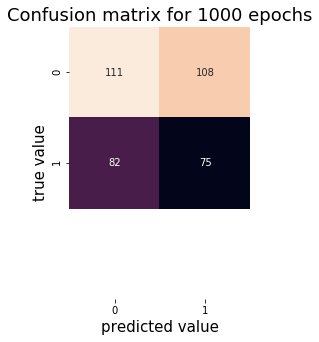

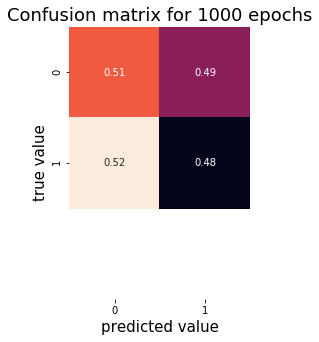

In [19]:
## 3

dailyChanges = pd.read_csv('./preprocessing/all_pricesAverages.csv')

SEQUENCE_SIZE = 8
X,y = to_sequences(SEQUENCE_SIZE, dailyChanges)

y = to_categorical(y) #Hot encode it

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)




history = None


def create_and_run_RNN_different_sequence( ep ):
        model = Sequential()
        model.add(SimpleRNN(16, input_shape=(None, 1)))
     
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu'))
            
        model.add(Dense(2, activation='softmax')) #One node for each category
        
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        model.summary()
  
        ##Regularization
        #monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        
        #######
        history = model.fit(X_train, y_train, epochs=ep, verbose=2, batch_size=5, validation_data=(X_test,y_test)) ##Fit the data
       
        #Evaluation
        ##Precision and recall
    
        pred = model.predict(X_test)
        history.pred = pred #save probability for last epochs test to evaluate
        pred = [np.argmax(x) for x in pred] #decode from one-hot encoding
        y_compare = [np.argmax(x) for x in y_test] #ecode from one-hot encoding
        history.y_compare = y_compare
        #accuracy
        acc = accuracy_score(y_compare, pred) ##For evaluation
        print("After {} epochs: Accuracy score: {}".format(ep, acc))
        cm = confusion_matrix(y_compare, pred) ##For evaluation later
        normalizedCm = cm.astype(float) / np.sum(cm, axis=1)[:,np.newaxis]
        print("After {} epochs: confusion matrix: {}".format(ep, cm))
       
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(cm, fmt='g', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        ##Normalized confusion matrix
        plt.figure(figsize=(5,5))
        #Show confion matrix for last epoch 
        plt.title("Confusion matrix for {} epochs".format(ep), fontsize=18)
        ax = sns.heatmap(normalizedCm, fmt='.2f', square=True, annot=True, cbar=False)
        ax.set_ylim(3,0) #maked heatmap showiung all squares
        plt.xlabel('predicted value', fontsize=15)
        plt.ylabel('true value',  fontsize=15);
        
        return history

model = create_and_run_RNN_different_sequence(1000) #Run with 200 epochs and the defauly RNN layer that is SimpleRNN



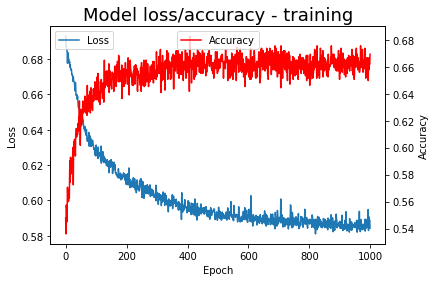

<Figure size 432x288 with 0 Axes>

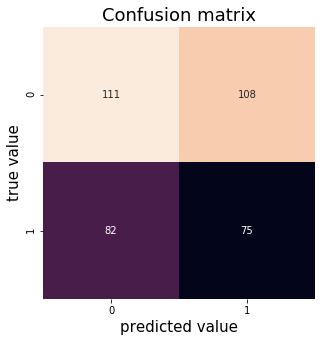

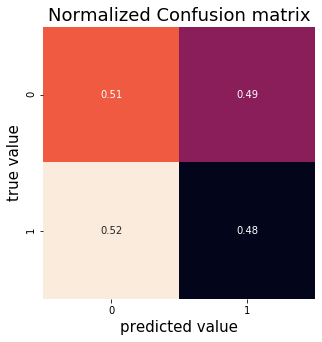

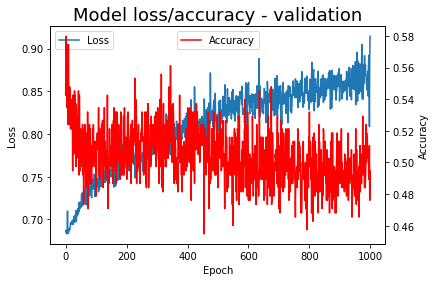

              precision    recall  f1-score   support

           0       0.58      0.51      0.54       219
           1       0.41      0.48      0.44       157

    accuracy                           0.49       376
   macro avg       0.49      0.49      0.49       376
weighted avg       0.51      0.49      0.50       376



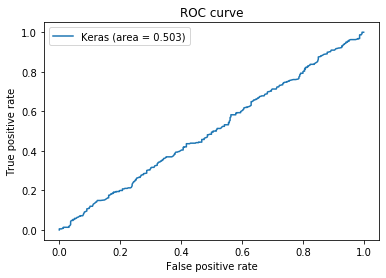

In [25]:
evaluate_mode(model)

## Result


    As mentioned before, the stock market has a complex pattern and there are billions of dollars put into the business of trying to predict where the stock will go the next day. Therefore, the market has no obvious function for the network to find. However, we had a very small dataset and a RNN of 7 days of daily price change.

    Also, the data set consisted of S&P 500 which is the 500 most traded stocks in the US. Therefore, it is most likely to correct itself in very unpredictable ways. The S&P 500 also consists of companies from a vast amount of different industries, which make the underlying price drivers very independent and not generalizable. 

    The features could also be enhanced by including technical indicators, such as volatilty, volume, and momentum indicators.

